A quick look at what's inside:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Sample rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5

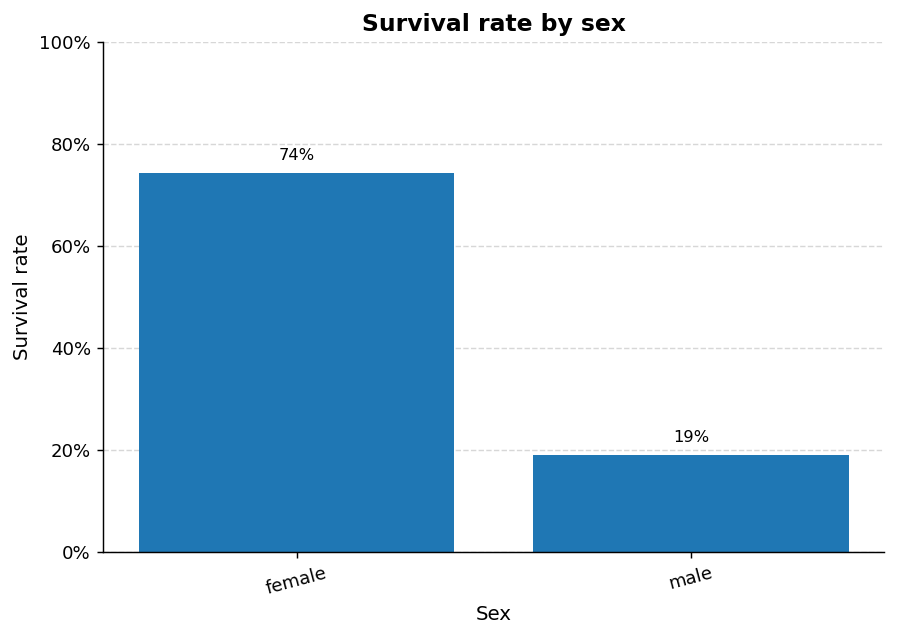

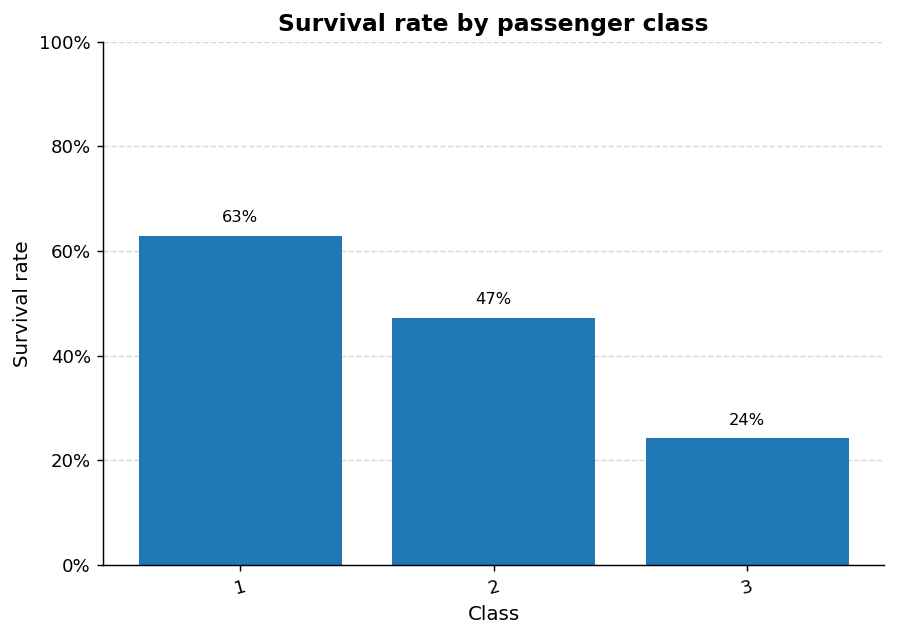

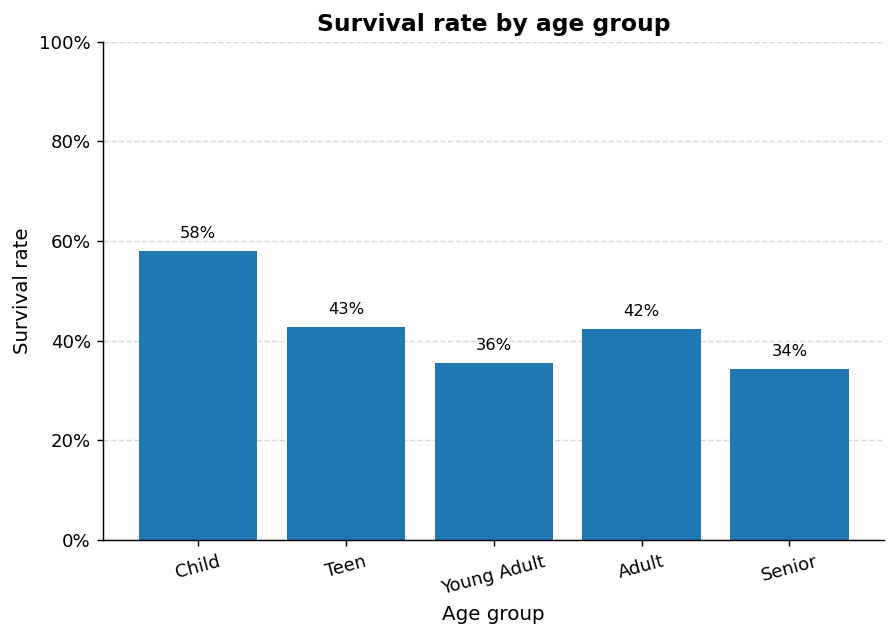

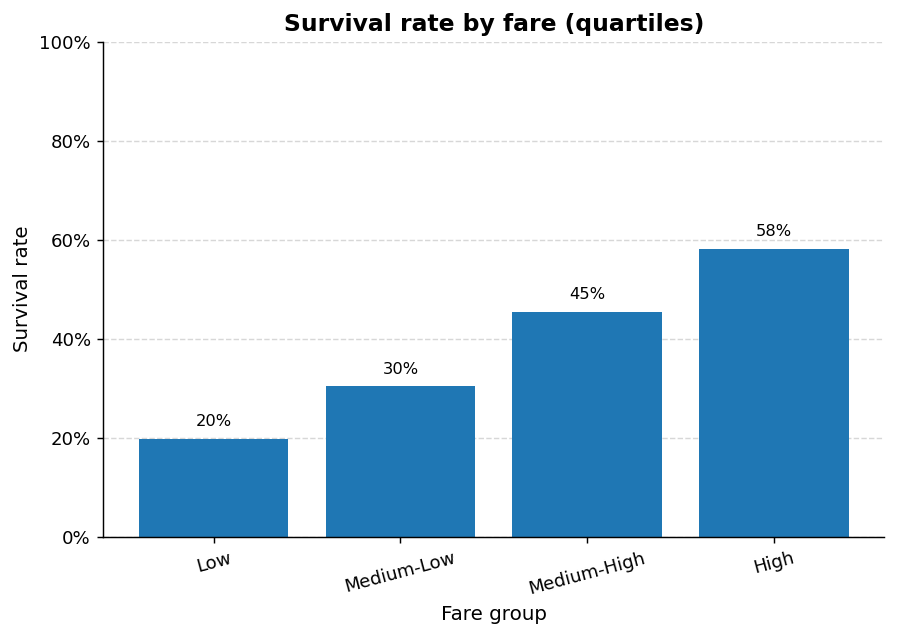

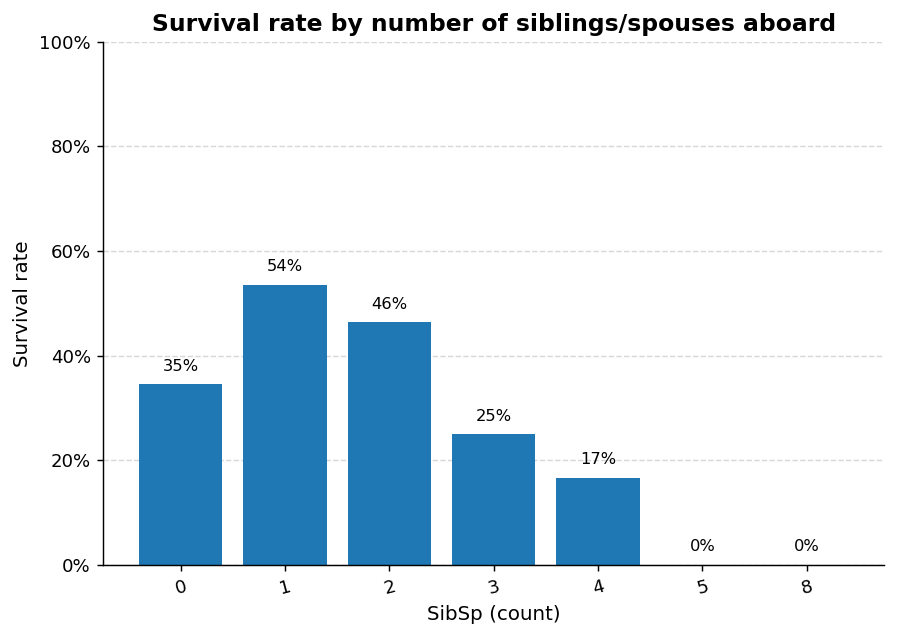

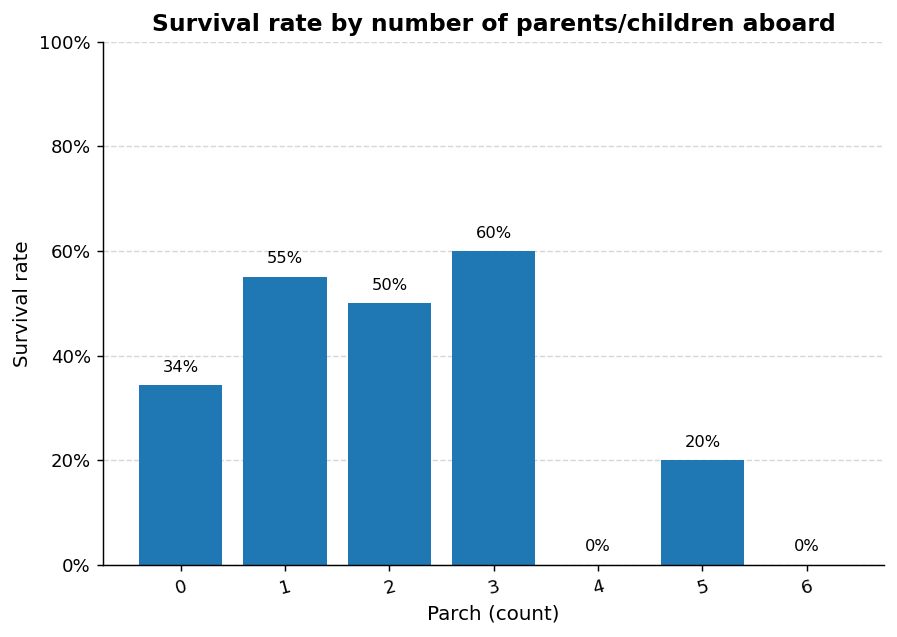

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
df = pd.read_csv("../data/raw/train.csv")
# --- Quick peek ---
print("A quick look at what's inside:")
print(df.info())
print("\nSample rows:")
print(df.head())

# --- Survival share overall ---
overall_survival_rate = df["Survived"].mean()
print(f"\nOverall survival share: {overall_survival_rate:.1%}")

# --- Feature engineering for bins ---
age_bins = [0, 12, 18, 30, 50, 80]
age_labels = ["Child", "Teen", "Young Adult", "Adult", "Senior"]
df["AgeBin"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, include_lowest=True)

df["FareBin"] = pd.qcut(df["Fare"], q=4,
                        labels=["Low", "Medium-Low", "Medium-High", "High"])

# --- Survival rates by group ---
survival_by_sex     = df.groupby("Sex", observed=True)["Survived"].mean().sort_values(ascending=False)
survival_by_pclass  = df.groupby("Pclass", observed=True)["Survived"].mean().sort_index()
survival_by_age     = df.groupby("AgeBin", observed=True)["Survived"].mean().reindex(age_labels)
survival_by_fare    = df.groupby("FareBin", observed=True)["Survived"].mean()  # already ordered
survival_by_sibsp = df.groupby("SibSp", observed=True)["Survived"].mean().sort_index()
survival_by_parch = df.groupby("Parch", observed=True)["Survived"].mean().sort_index()

def pretty_print_percent(series, title):
    print(f"\n{title}")
    print(series.apply(lambda v: f"{v:.1%}"))

pretty_print_percent(survival_by_sex,    "Survival by sex")
pretty_print_percent(survival_by_pclass, "Survival by passenger class")
pretty_print_percent(survival_by_age,    "Survival by age group")
pretty_print_percent(survival_by_fare,   "Survival by fare quartile")
pretty_print_percent(survival_by_sibsp, "Survival by siblings/spouses aboard (SibSp)")
pretty_print_percent(survival_by_parch, "Survival by parents/children aboard (Parch)")

# --- Plot settings for a cleaner look (no custom colors) ---
plt.rcParams.update({
    "figure.dpi": 130,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "semibold",
    "axes.labelsize": 11,
    "axes.titlesize": 13,
})

def plot_rate(series, title, xlabel=None):
    """Bar chart with % labels and a light grid (one figure per chart)."""
    series = series.dropna()
    fig, ax = plt.subplots(figsize=(7, 5))
    x = series.index.astype(str)
    y = series.values

    ax.bar(x, y)  # no explicit colors/styles per request
    ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    ax.set_ylabel("Survival rate")
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_axisbelow(True)
    for i, v in enumerate(y):
        ax.text(i, v + 0.02, f"{v:.0%}", ha="center", va="bottom", fontsize=9)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# --- Charts (one per figure for clarity) ---
plot_rate(survival_by_sex,    "Survival rate by sex", "Sex")
plot_rate(survival_by_pclass, "Survival rate by passenger class", "Class")
plot_rate(survival_by_age,    "Survival rate by age group", "Age group")
plot_rate(survival_by_fare,   "Survival rate by fare (quartiles)", "Fare group")
plot_rate(survival_by_sibsp, "Survival rate by number of siblings/spouses aboard", "SibSp (count)")
plot_rate(survival_by_parch, "Survival rate by number of parents/children aboard", "Parch (count)")



In [4]:
import pandas as pd
import re

# Load the dataset (assuming train.csv is in your directory)
df = pd.read_csv('../data/raw/train.csv')

def add_titanic_features(df: pd.DataFrame) -> pd.DataFrame:
    x = df.copy()
    # Family size & companions
    x["SibSp"] = x["SibSp"].fillna(0)
    x["Parch"] = x["Parch"].fillna(0)
    x["FamilySize"] = x["SibSp"] + x["Parch"] + 1
    x["IsAlone"] = (x["FamilySize"] == 1).astype(int)
    # Title from name
    titles = x["Name"].str.extract(r",\s*([^\.]+)\.")[0]
    titles = titles.replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
    common = {"Mr", "Mrs", "Miss", "Master"}
    x["Title"] = titles.where(titles.isin(common), "Rare")
    # Ticket prefix
    tk = x["Ticket"].astype(str)
    tk = tk.str.replace(r"[\./]", "", regex=True)
    tk = tk.str.replace(r"\d", "", regex=True).str.strip().str.upper()
    x["TicketPrefix"] = tk.replace("", "NONE")
    # Cabin deck
    cab = x["Cabin"].fillna("U").astype(str)
    x["CabinDeck"] = cab.str[0].str.upper()
    x["HasCabin"] = (x["CabinDeck"] != "U").astype(int)
    # Interactions
    x["FarePerPerson"] = x["Fare"] / x["FamilySize"].replace(0, 1)
    x["AgeTimesClass"] = x["Age"] * x["Pclass"]
    return x

# Apply feature engineering
data = add_titanic_features(df)

# Inspect the first few rows
print("Intermediate DataFrame after feature engineering:")
print(data[['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
            'Embarked', 'FamilySize', 'IsAlone', 'Title', 'TicketPrefix', 'CabinDeck', 
            'HasCabin', 'FarePerPerson', 'AgeTimesClass']].head())

# Check unique values for categorical features
print("\nUnique values in categorical features:")
print("Sex:", data['Sex'].unique())
print("Embarked:", data['Embarked'].unique())
print("Title:", data['Title'].unique())
print("TicketPrefix:", data['TicketPrefix'].unique())
print("CabinDeck:", data['CabinDeck'].unique())
print("Pclass:", data['Pclass'].unique())

Intermediate DataFrame after feature engineering:
   PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare  \
0            1         0       3    male  22.0      1      0   7.2500   
1            2         1       1  female  38.0      1      0  71.2833   
2            3         1       3  female  26.0      0      0   7.9250   
3            4         1       1  female  35.0      1      0  53.1000   
4            5         0       3    male  35.0      0      0   8.0500   

  Embarked  FamilySize  IsAlone Title TicketPrefix CabinDeck  HasCabin  \
0        S           2        0    Mr            A         U         0   
1        C           2        0   Mrs           PC         C         1   
2        S           1        1  Miss        STONO         U         0   
3        S           2        0   Mrs         NONE         C         1   
4        S           1        1    Mr         NONE         U         0   

   FarePerPerson  AgeTimesClass  
0        3.62500           66.0 

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def build_matrix(df: pd.DataFrame, target_col: str = "Survived"):
    data = add_titanic_features(df)
    categorical = ["Sex", "Embarked", "Title", "CabinDeck", "TicketPrefix", "Pclass"]
    numeric = ["Age", "Fare", "FamilySize", "FarePerPerson", "AgeTimesClass", "SibSp", "Parch", "IsAlone", "HasCabin"]
    categorical = [c for c in categorical if c in data.columns]
    numeric = [c for c in numeric if c in data.columns]
    numeric_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, numeric),
            ("cat", categorical_pipe, categorical),
        ],
        remainder="drop"
    )
    X = data[numeric + categorical]
    y = data[target_col].astype(int) if target_col in data.columns else None
    X_trans = preprocessor.fit_transform(X)
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_names = list(ohe.get_feature_names_out(categorical))
    feature_names = numeric + cat_names
    X_dense = X_trans.toarray() if hasattr(X_trans, "toarray") else X_trans
    X_df = pd.DataFrame(X_dense, columns=feature_names, index=X.index)
    return X_df, y, preprocessor, feature_names

# Apply preprocessing
X_df, y, preprocessor, feature_names = build_matrix(df)

# Inspect output
print(f"X shape: {X_df.shape}")
print("First features:", feature_names[:10])
print("Sample rows:")
print(X_df.head())

X shape: (891, 60)
First features: ['Age', 'Fare', 'FamilySize', 'FarePerPerson', 'AgeTimesClass', 'SibSp', 'Parch', 'IsAlone', 'HasCabin', 'Sex_female']
Sample rows:
        Age      Fare  FamilySize  FarePerPerson  AgeTimesClass     SibSp  \
0 -0.565736 -0.502445    0.059160      -0.454798       0.157307  0.432793   
1  0.663861  0.786845    0.059160       0.438994      -0.751947  0.432793   
2 -0.258337 -0.488854   -0.560975      -0.334757       0.546987 -0.474545   
3  0.433312  0.420730    0.059160       0.185187      -0.849367  0.432793   
4  0.433312 -0.486337   -0.560975      -0.331267       1.423767 -0.474545   

      Parch   IsAlone  HasCabin  Sex_female  ...  TicketPrefix_SOTONO  \
0 -0.473674 -1.231645 -0.544925         0.0  ...                  0.0   
1 -0.473674 -1.231645  1.835115         1.0  ...                  0.0   
2 -0.473674  0.811922 -0.544925         1.0  ...                  0.0   
3 -0.473674 -1.231645  1.835115         1.0  ...                  0.0   
4 -0.

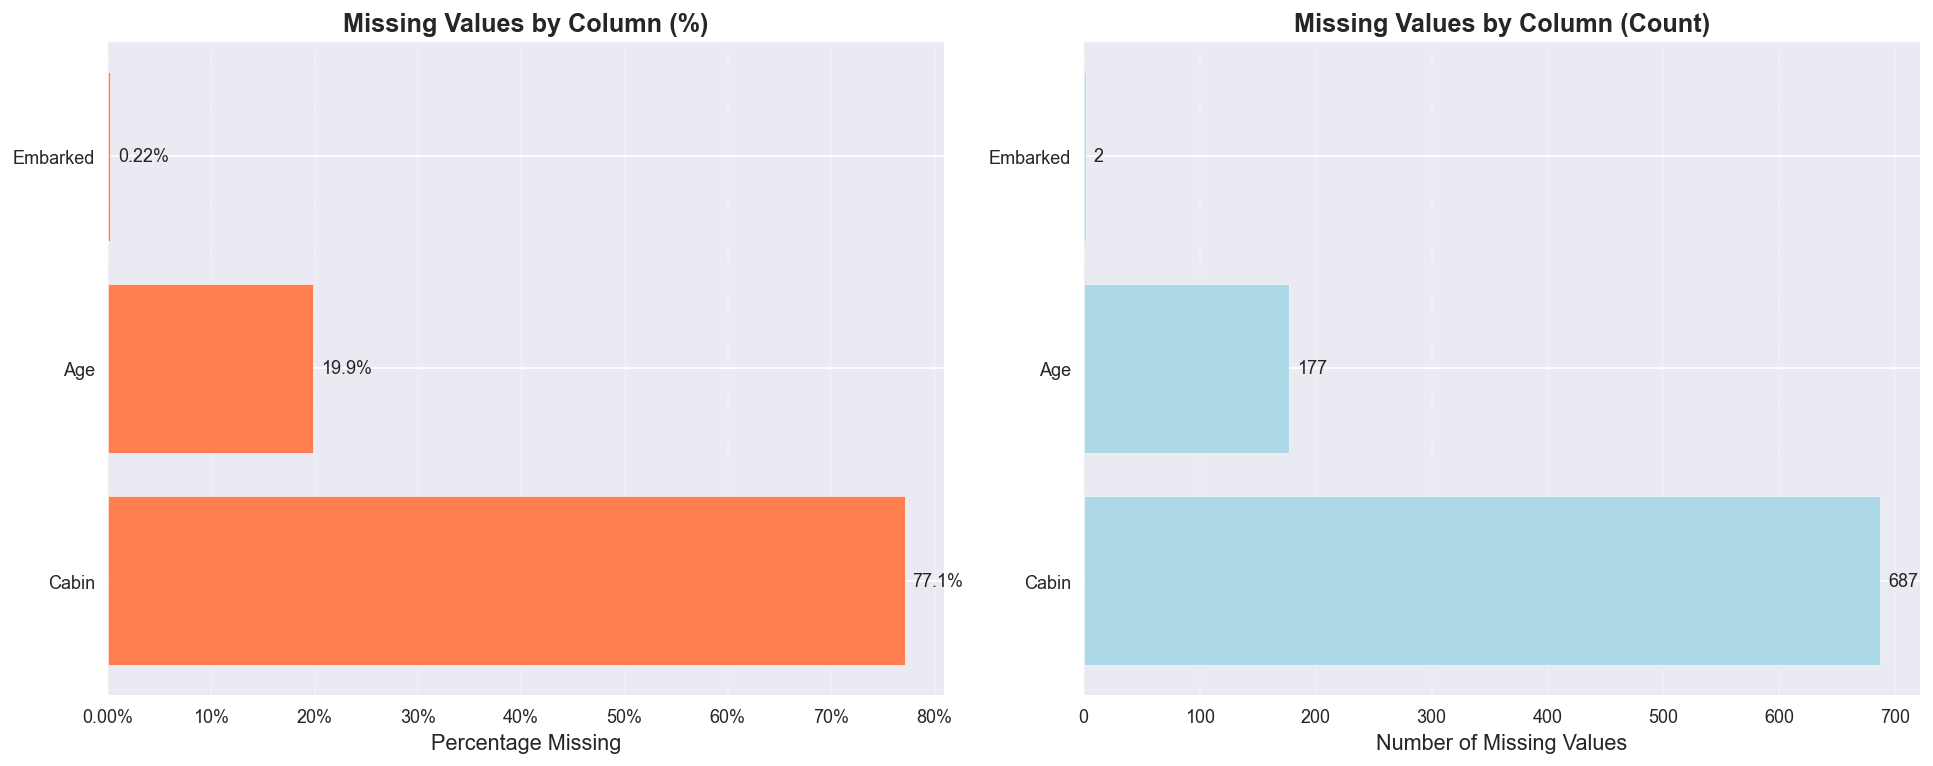

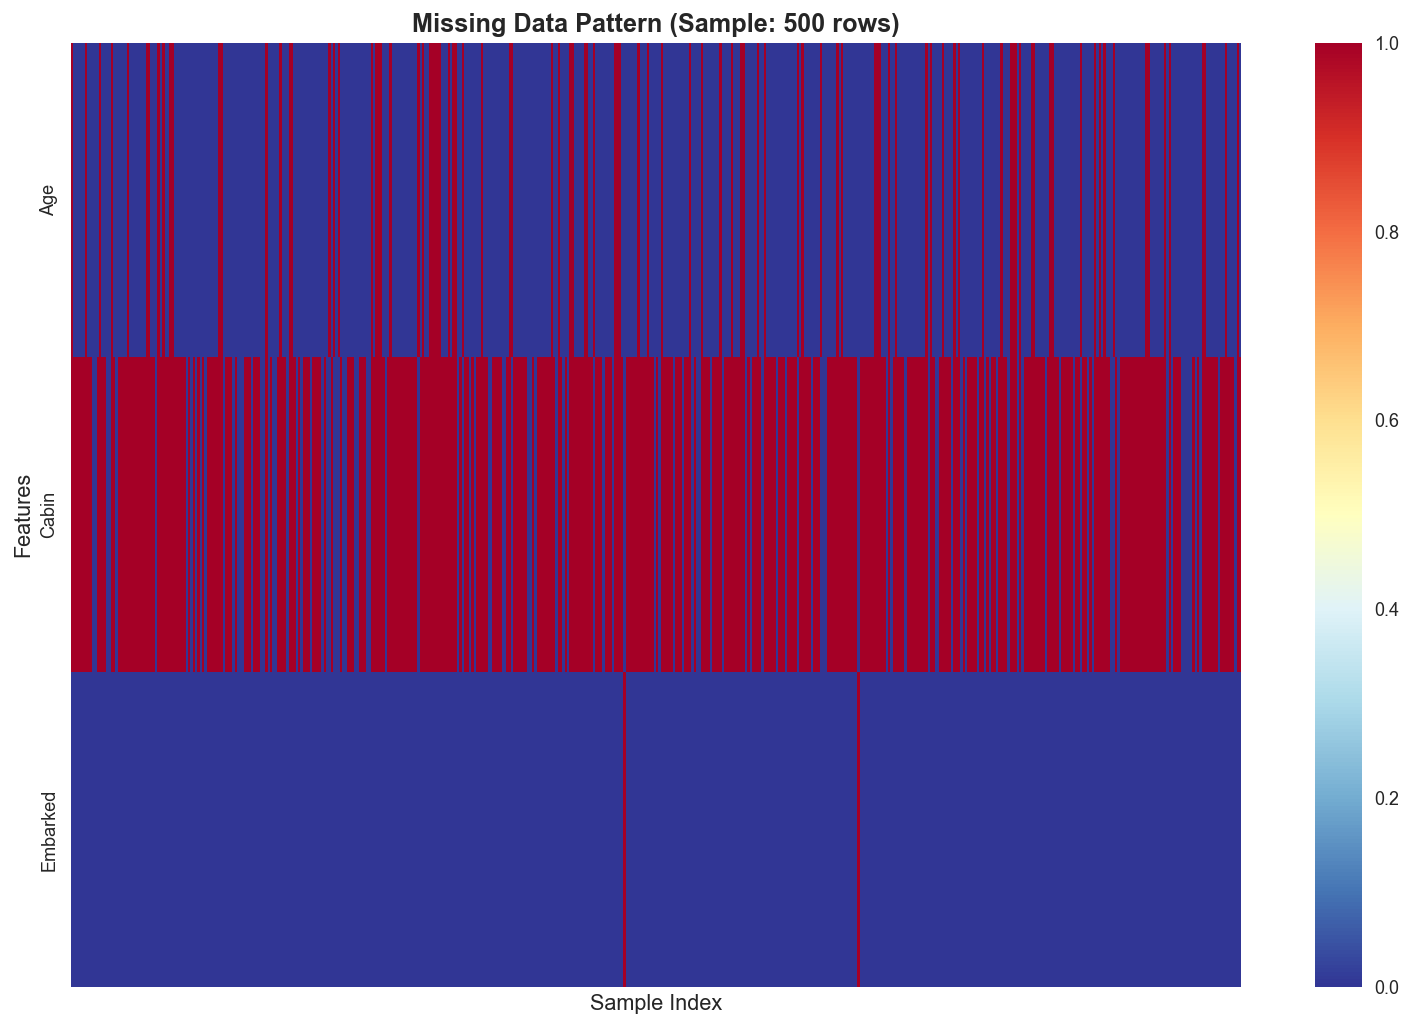

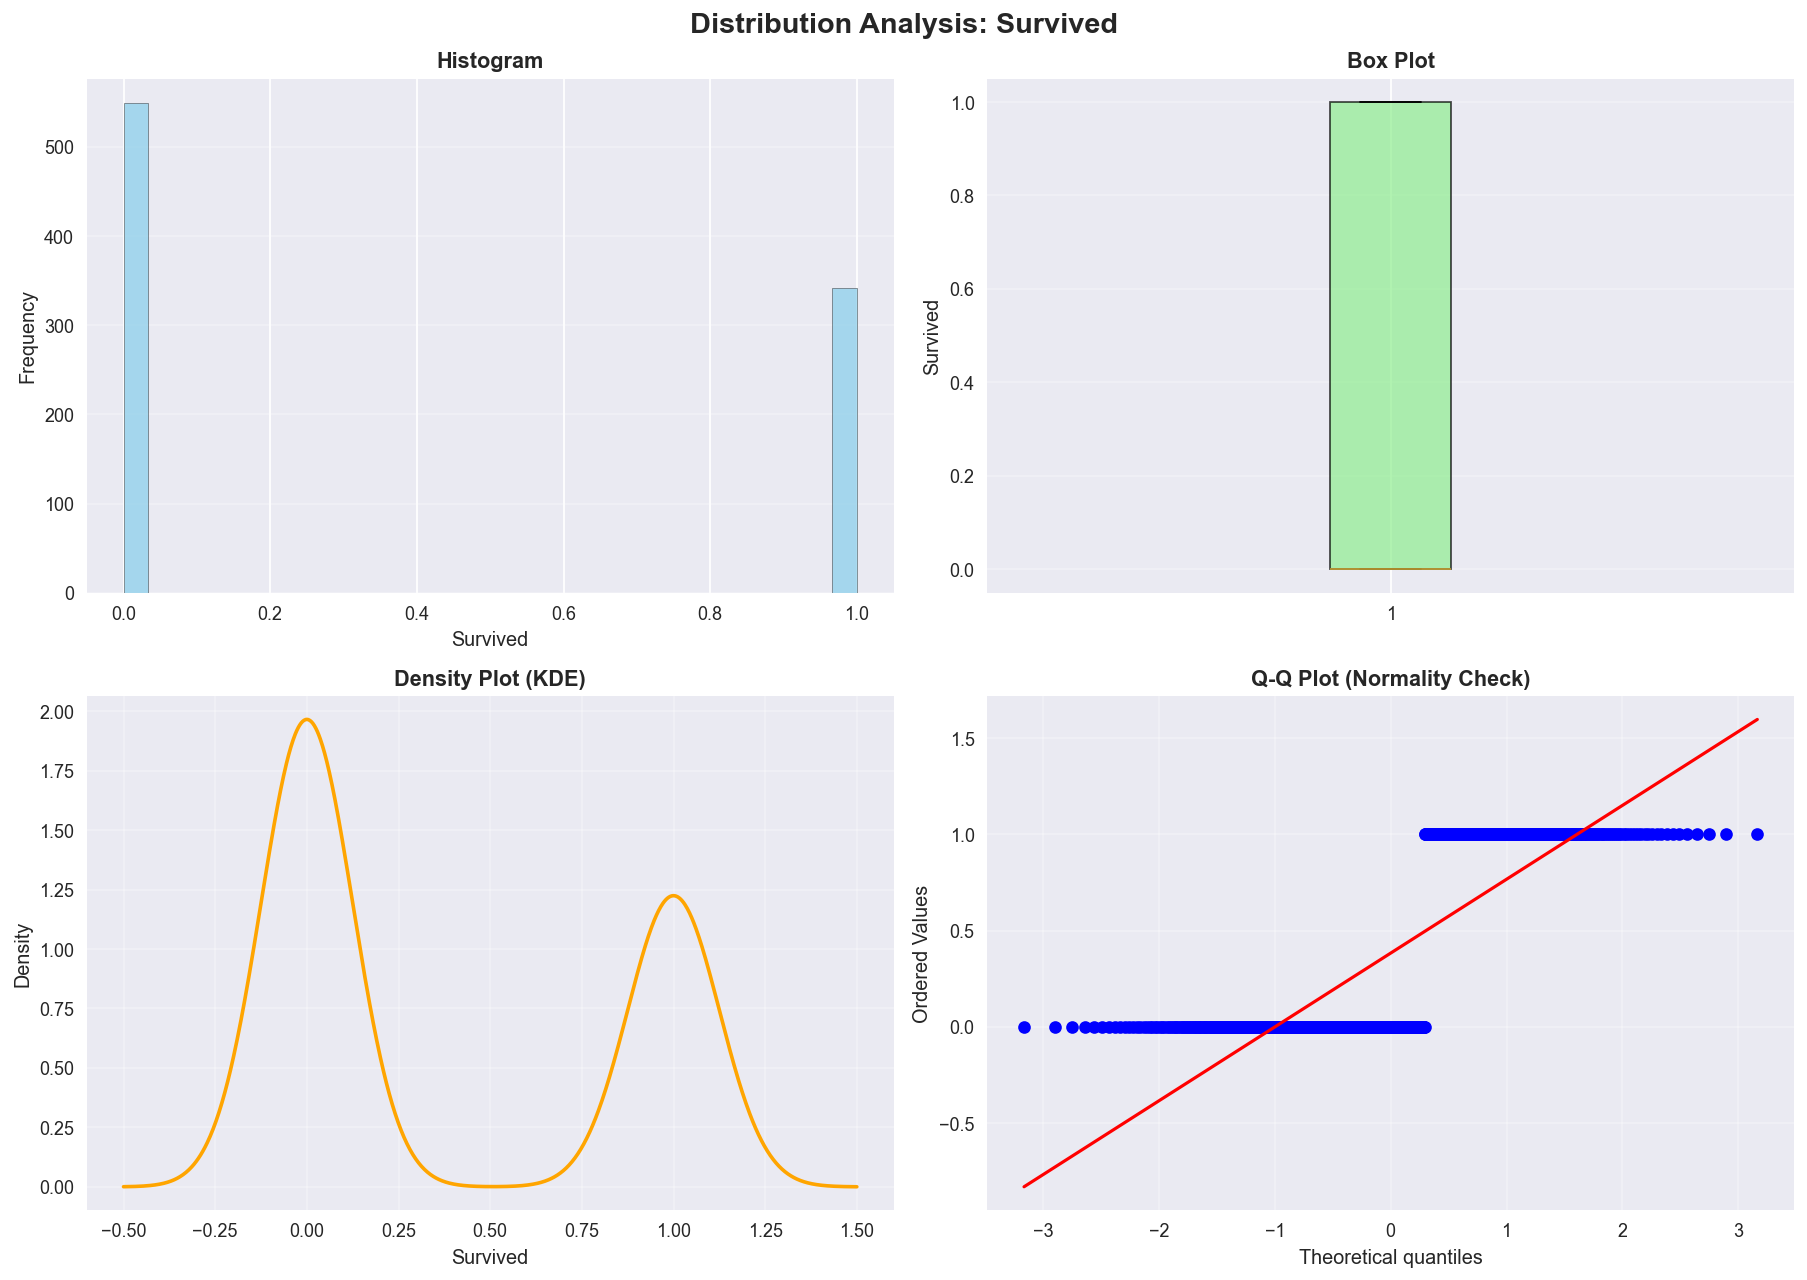


Survived - Summary Statistics:
Mean: 0.384 | Median: 0.000
Std: 0.487 | Skewness: 0.479
Min: 0.000 | Max: 1.000
--------------------------------------------------


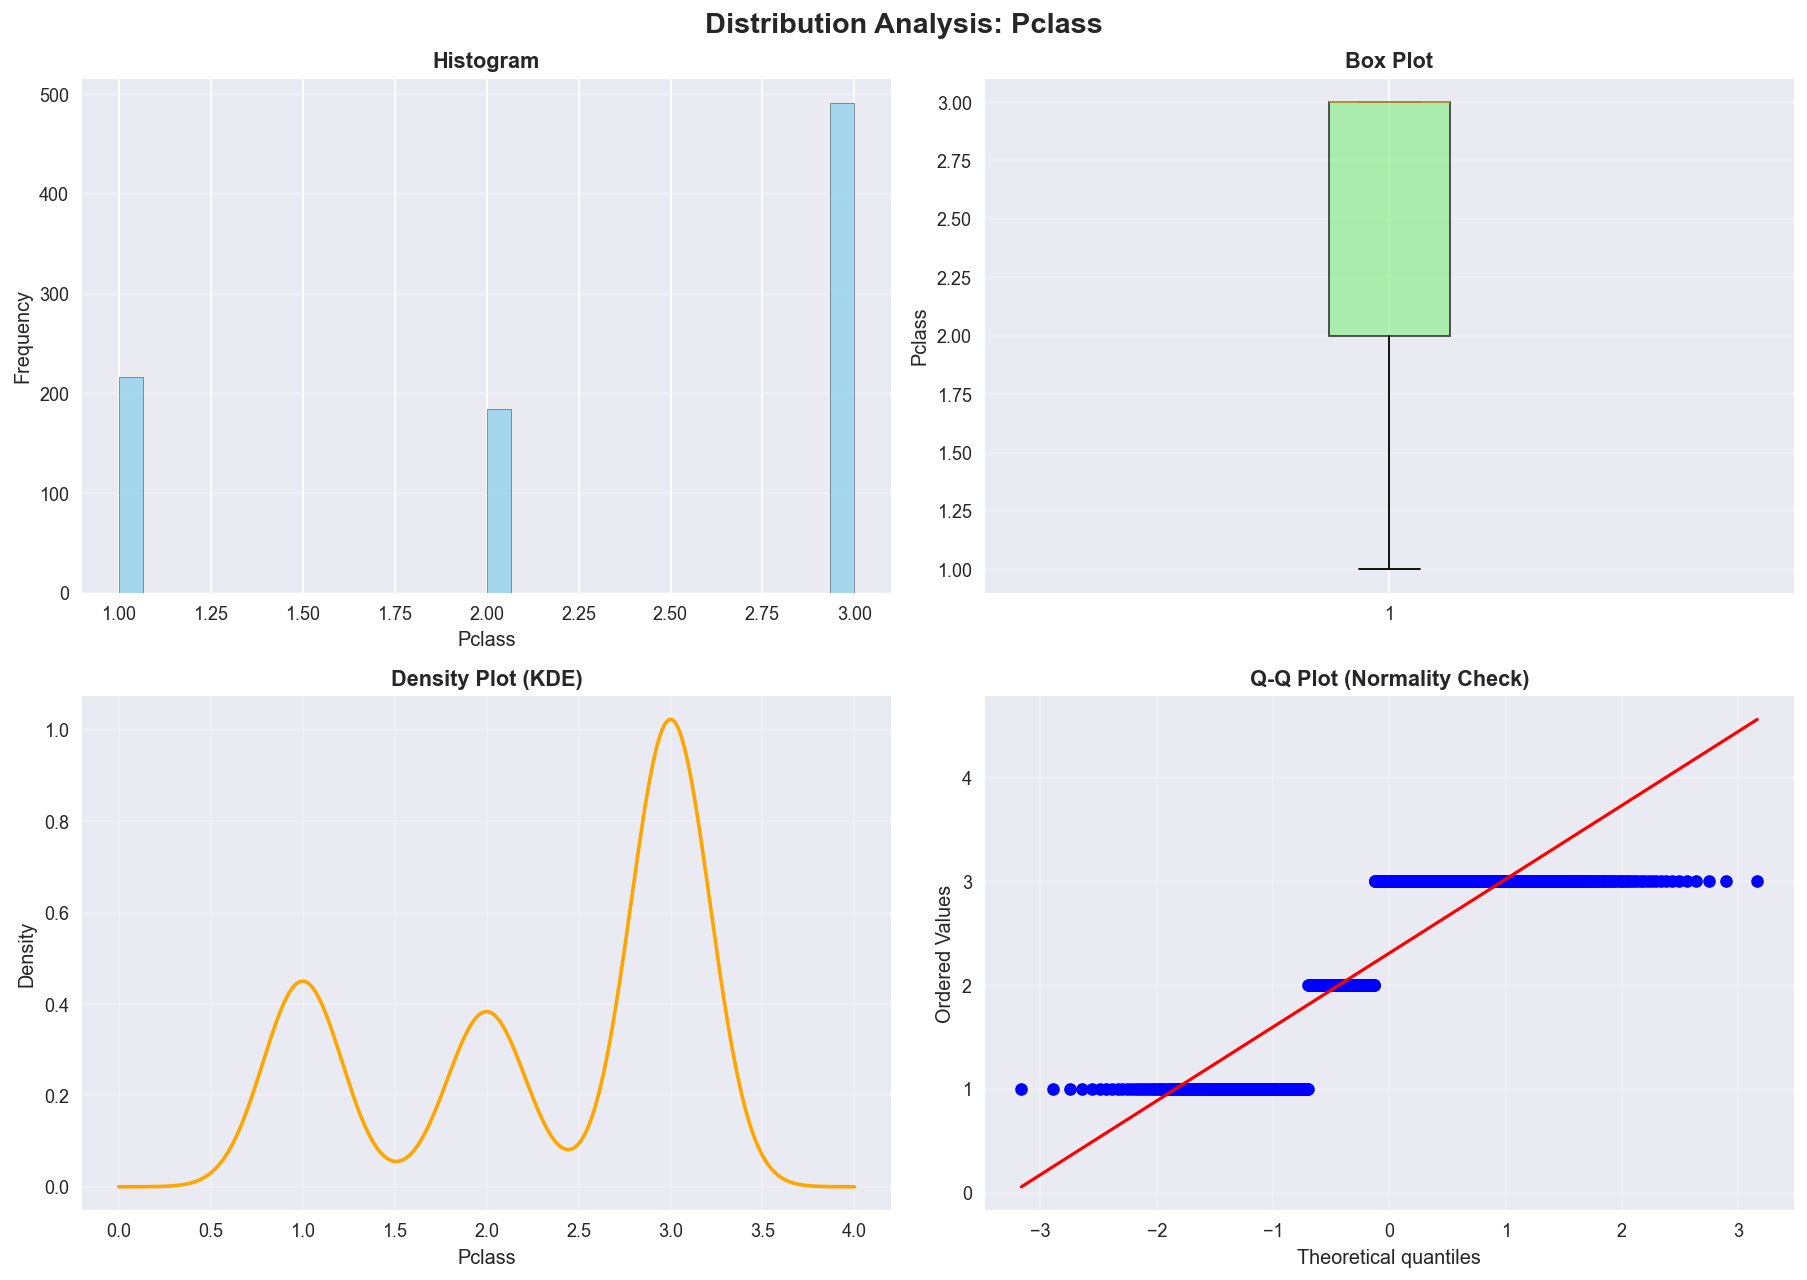


Pclass - Summary Statistics:
Mean: 2.309 | Median: 3.000
Std: 0.836 | Skewness: -0.631
Min: 1.000 | Max: 3.000
--------------------------------------------------


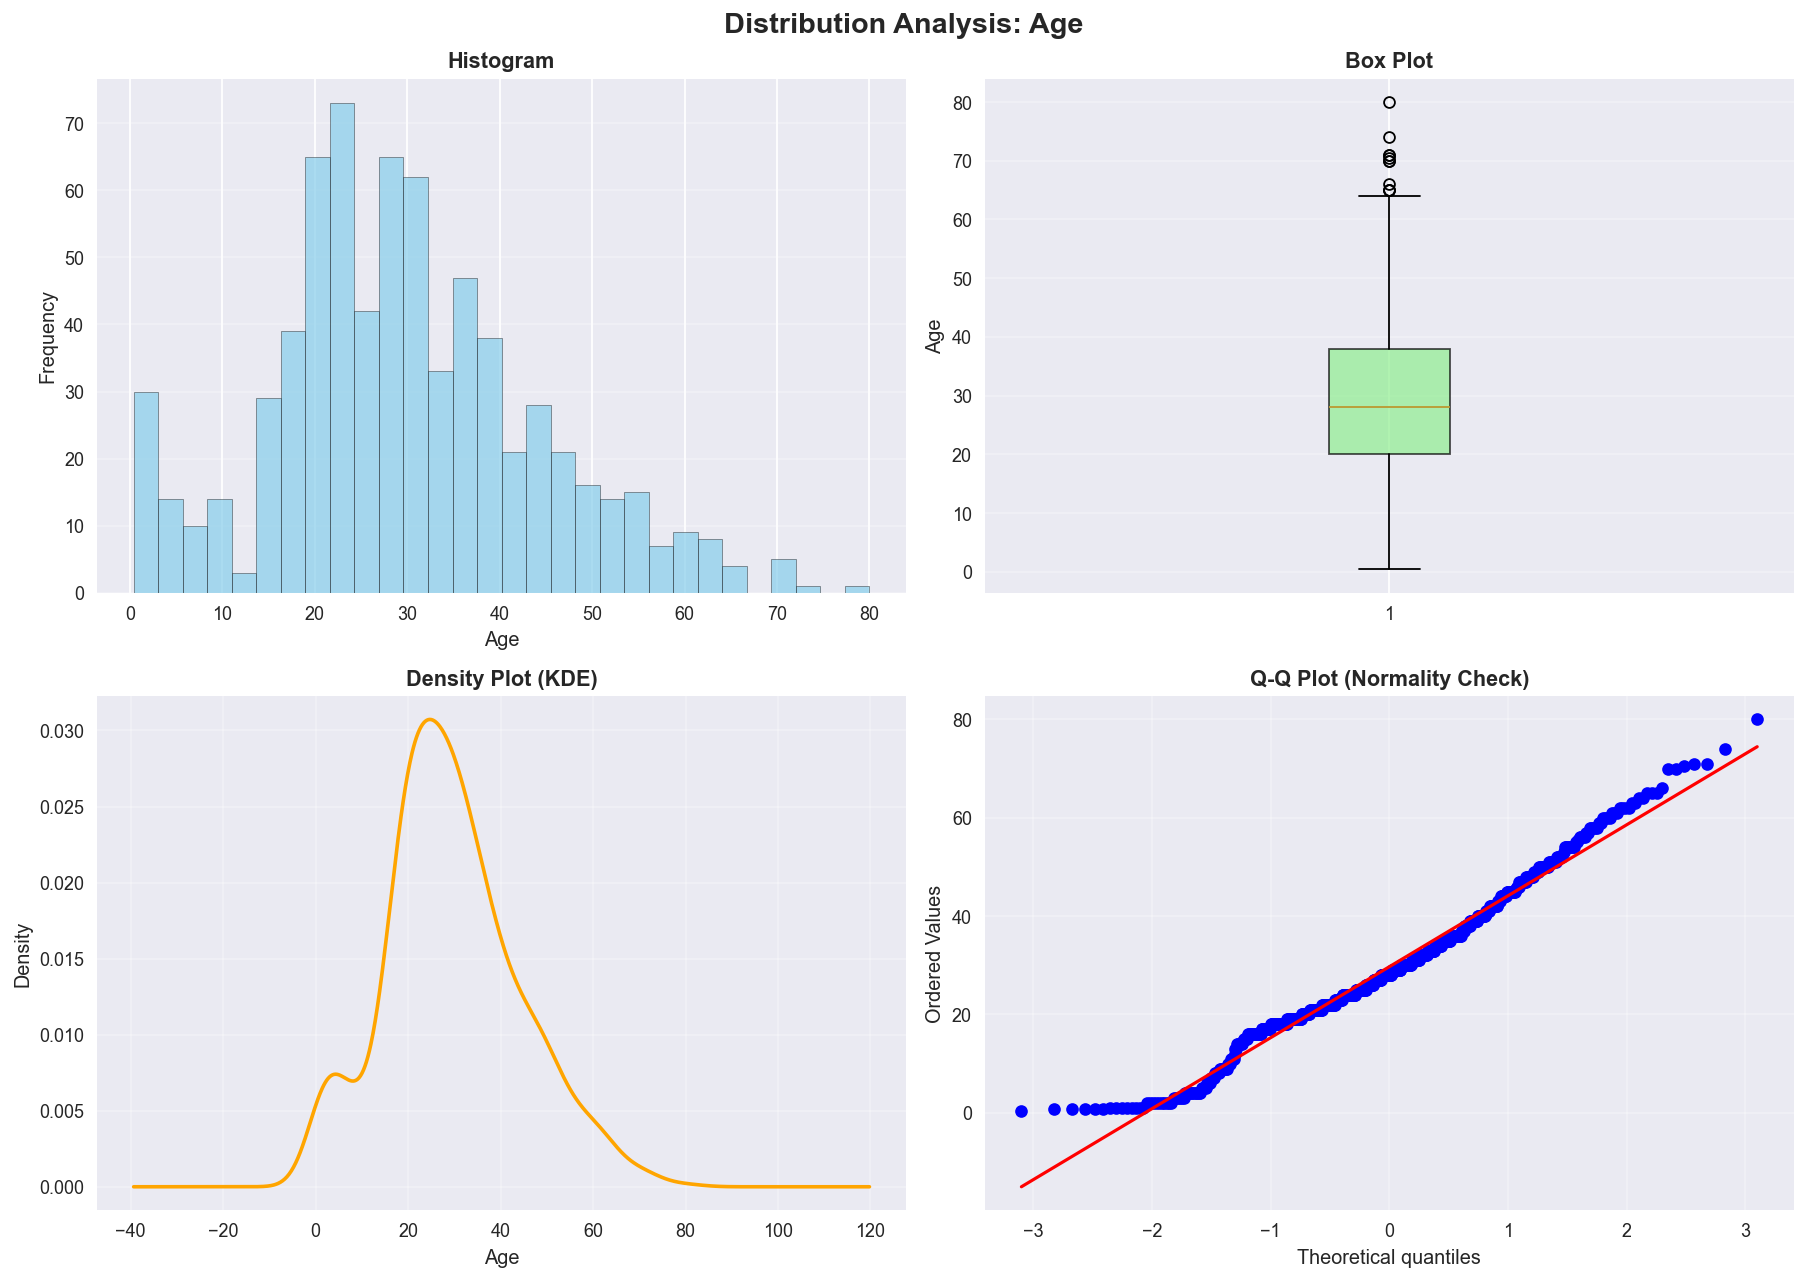


Age - Summary Statistics:
Mean: 29.699 | Median: 28.000
Std: 14.526 | Skewness: 0.389
Min: 0.420 | Max: 80.000
--------------------------------------------------


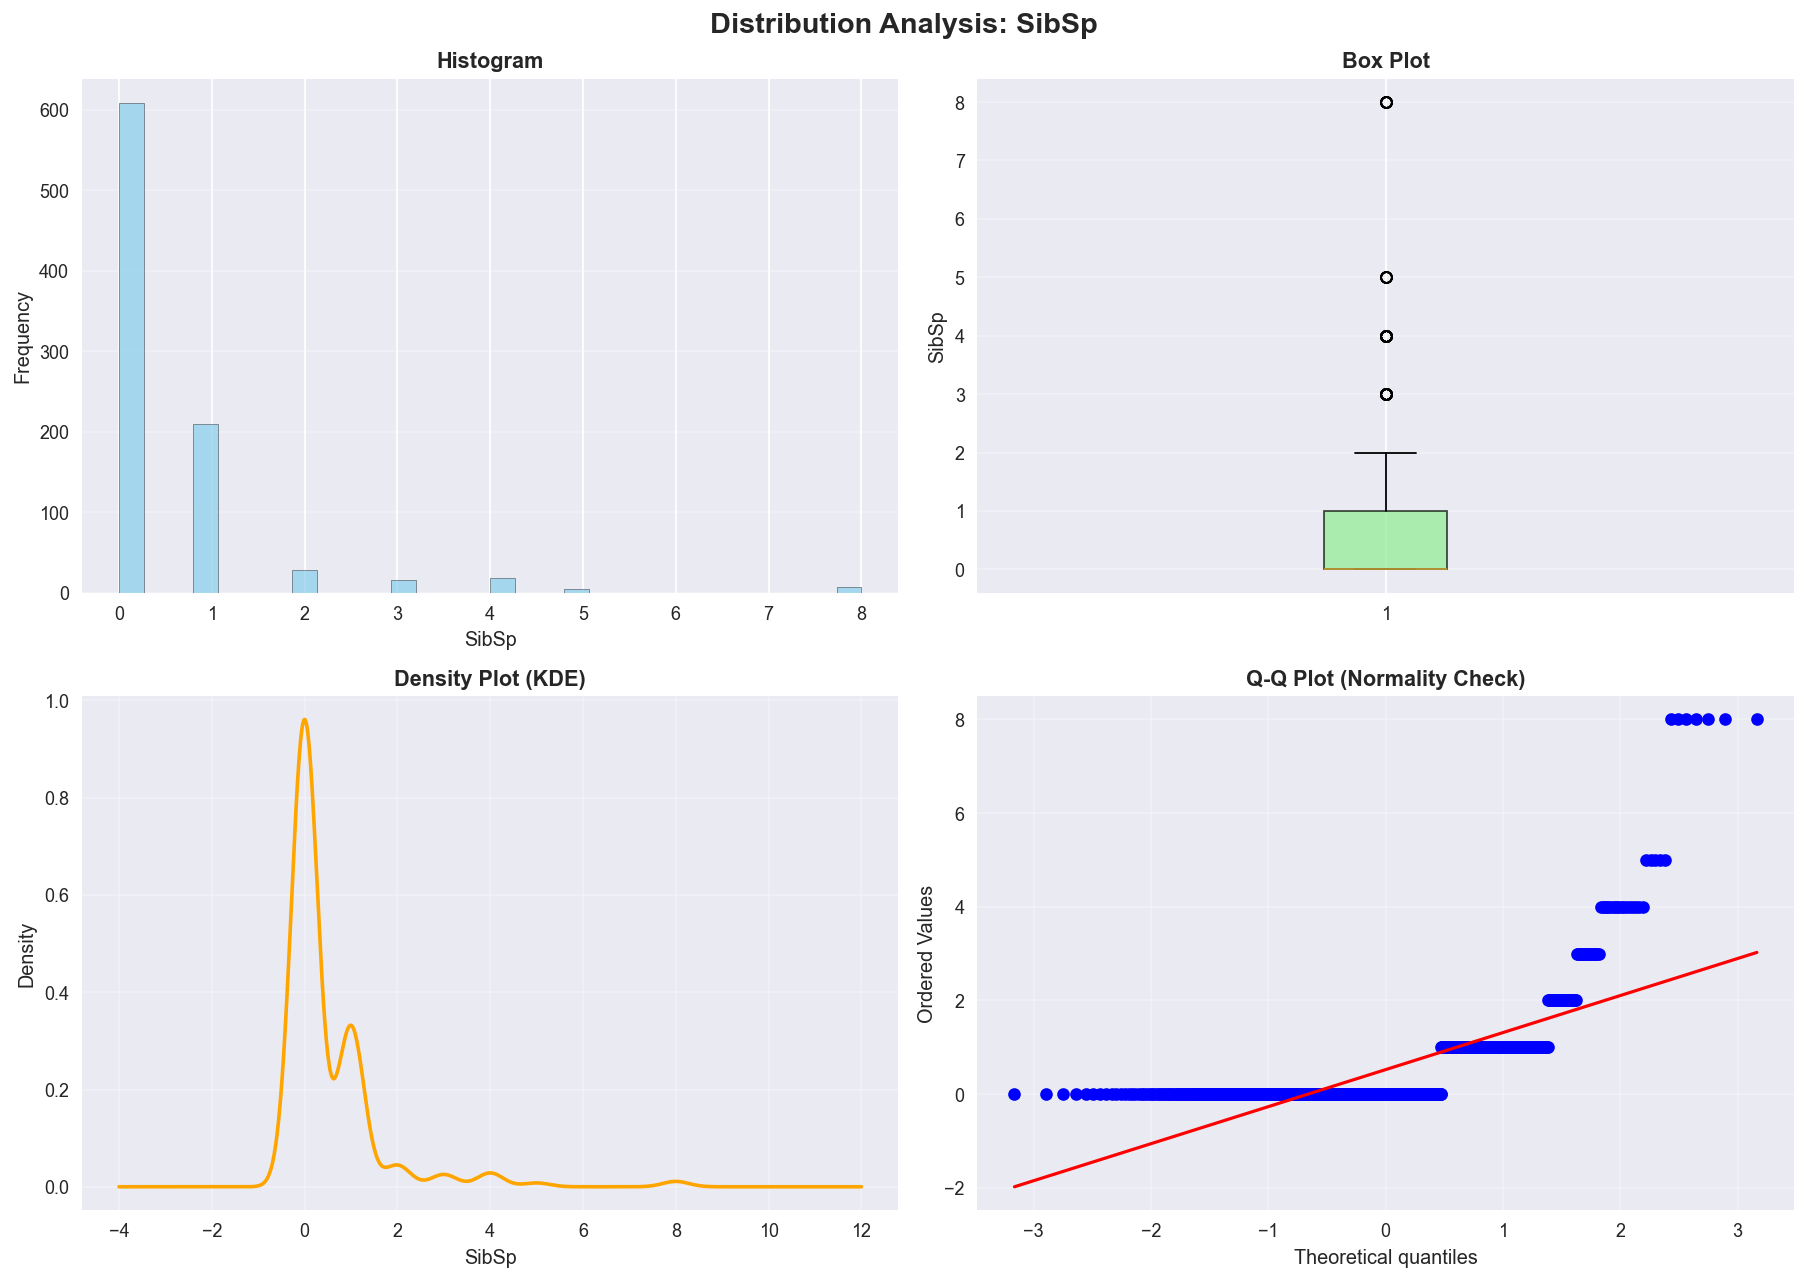


SibSp - Summary Statistics:
Mean: 0.523 | Median: 0.000
Std: 1.103 | Skewness: 3.695
Min: 0.000 | Max: 8.000
--------------------------------------------------


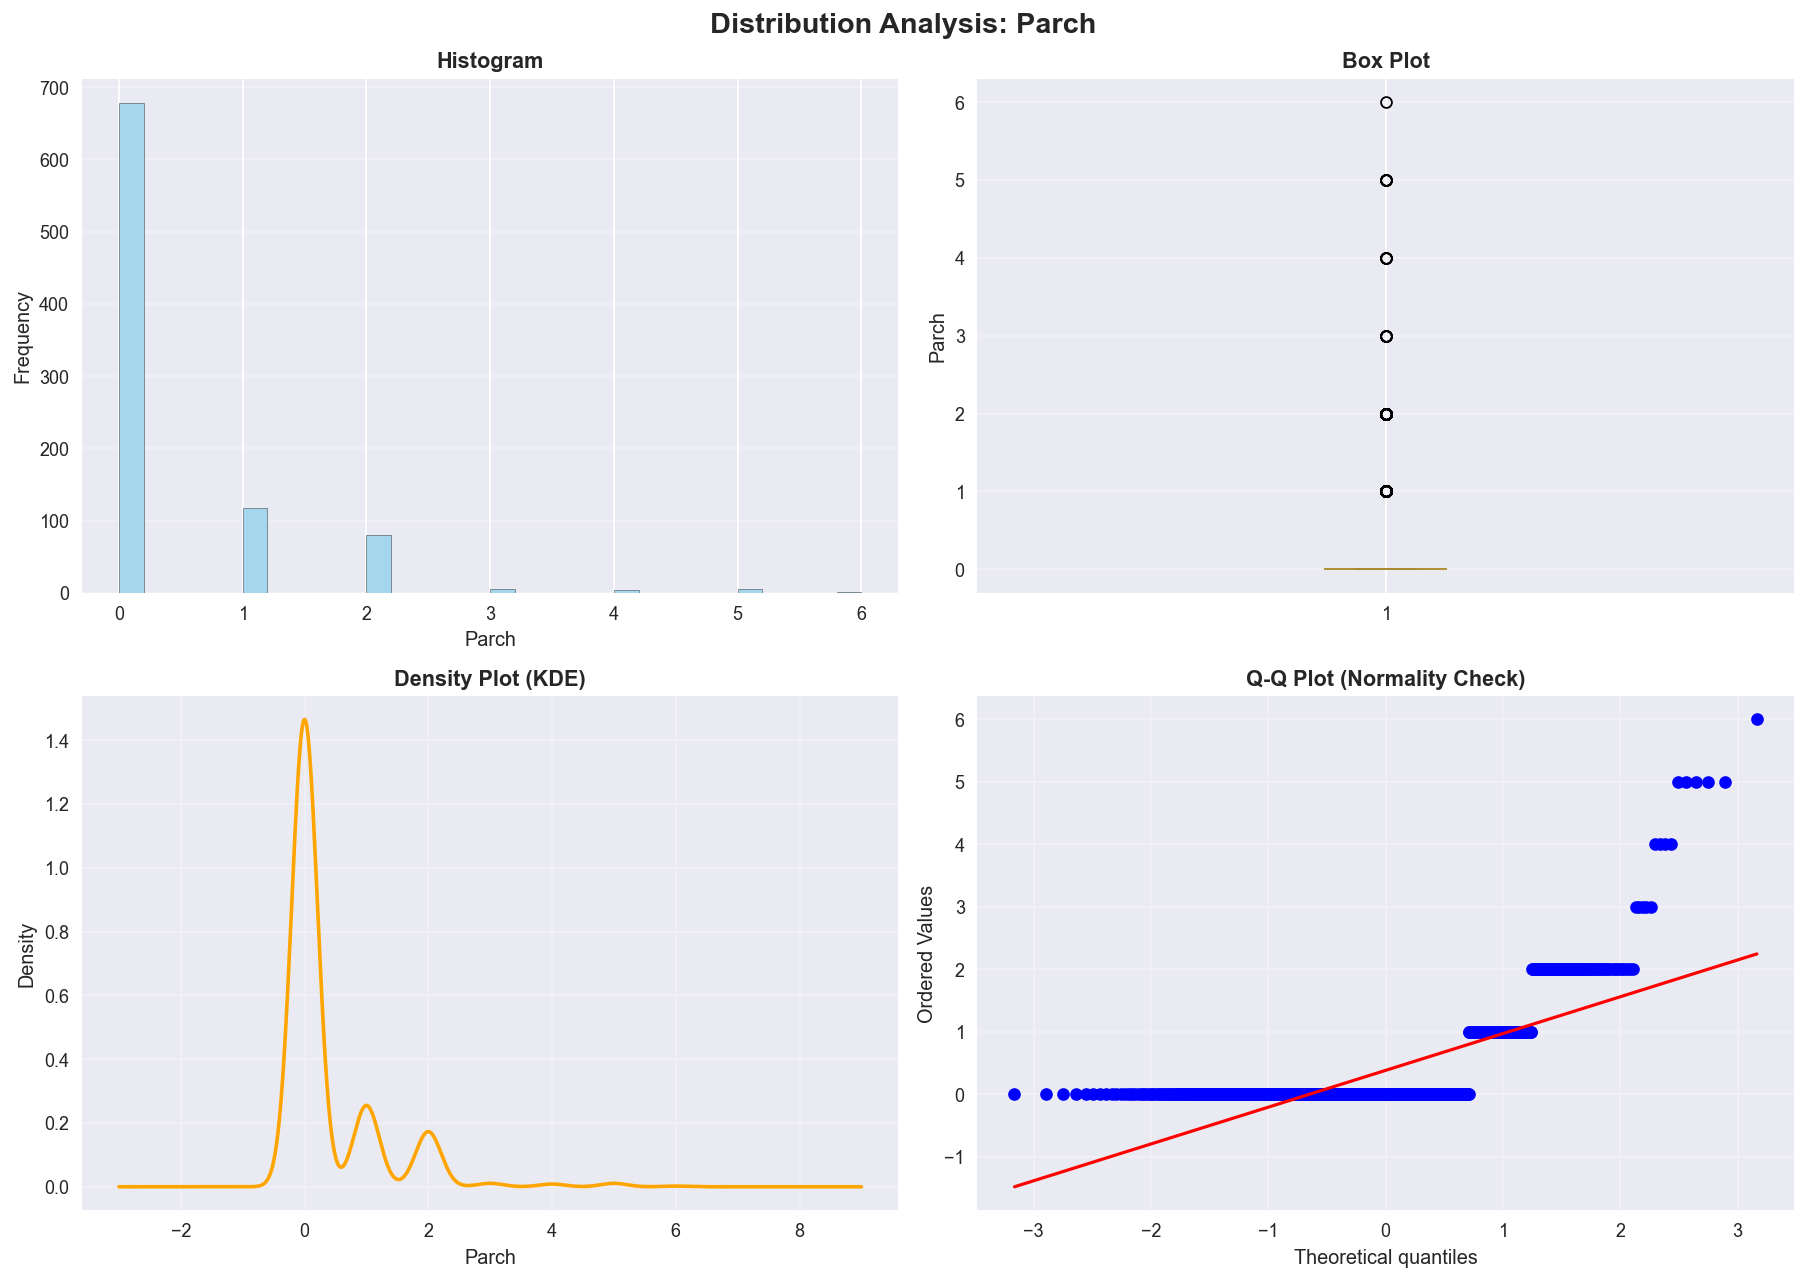


Parch - Summary Statistics:
Mean: 0.382 | Median: 0.000
Std: 0.806 | Skewness: 2.749
Min: 0.000 | Max: 6.000
--------------------------------------------------


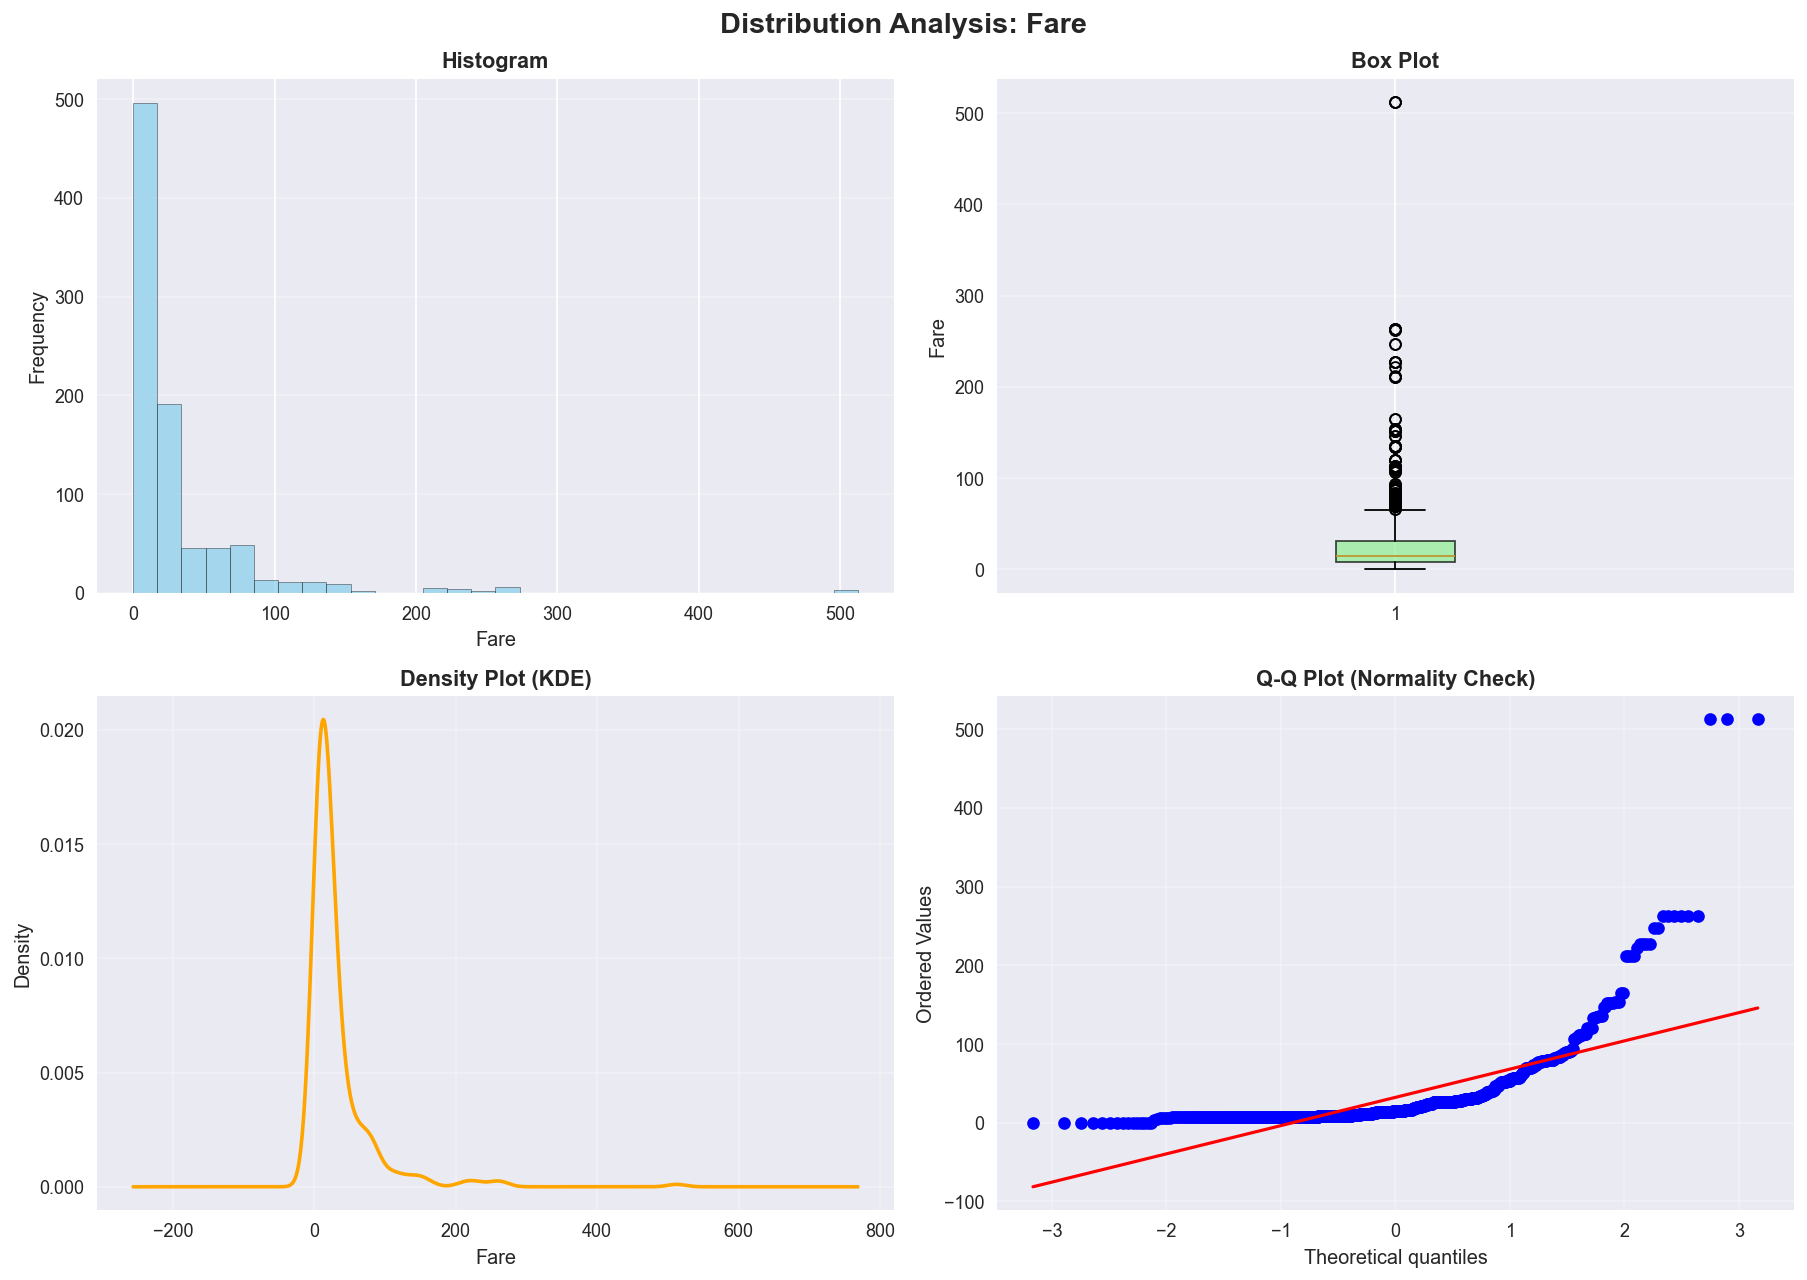


Fare - Summary Statistics:
Mean: 32.204 | Median: 14.454
Std: 49.693 | Skewness: 4.787
Min: 0.000 | Max: 512.329
--------------------------------------------------


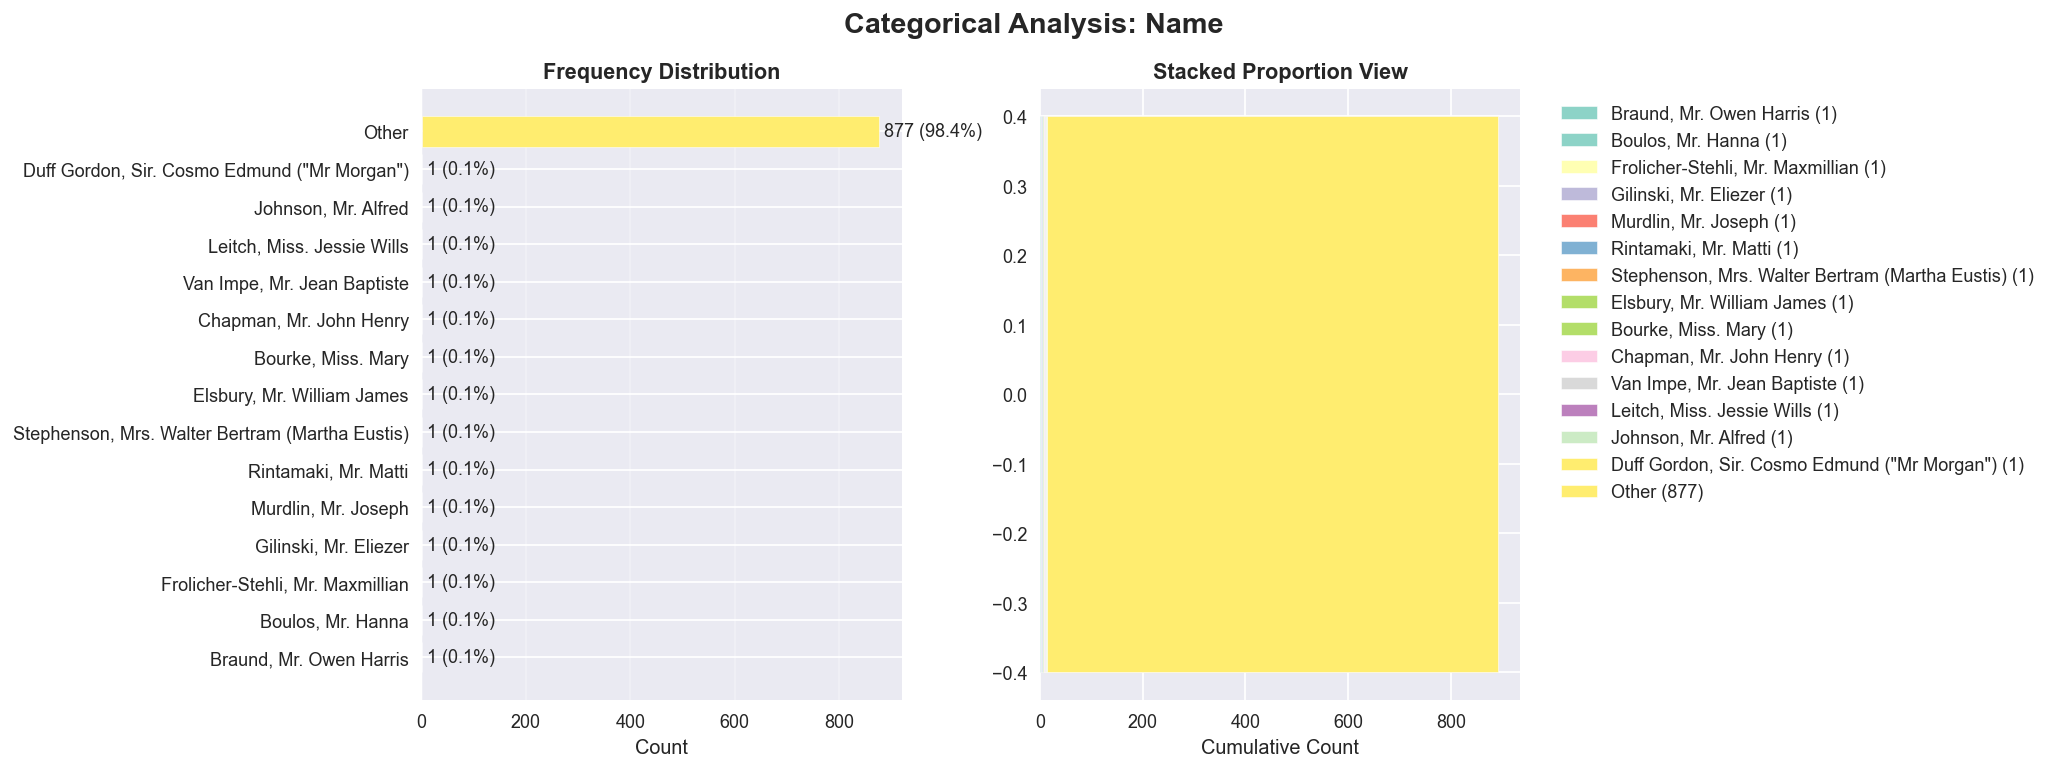


Name - Category Summary:
Unique categories: 15
Most common: Braund, Mr. Owen Harris (1 occurrences, 0.1%)
Least common: Other (877 occurrences, 98.4%)
--------------------------------------------------


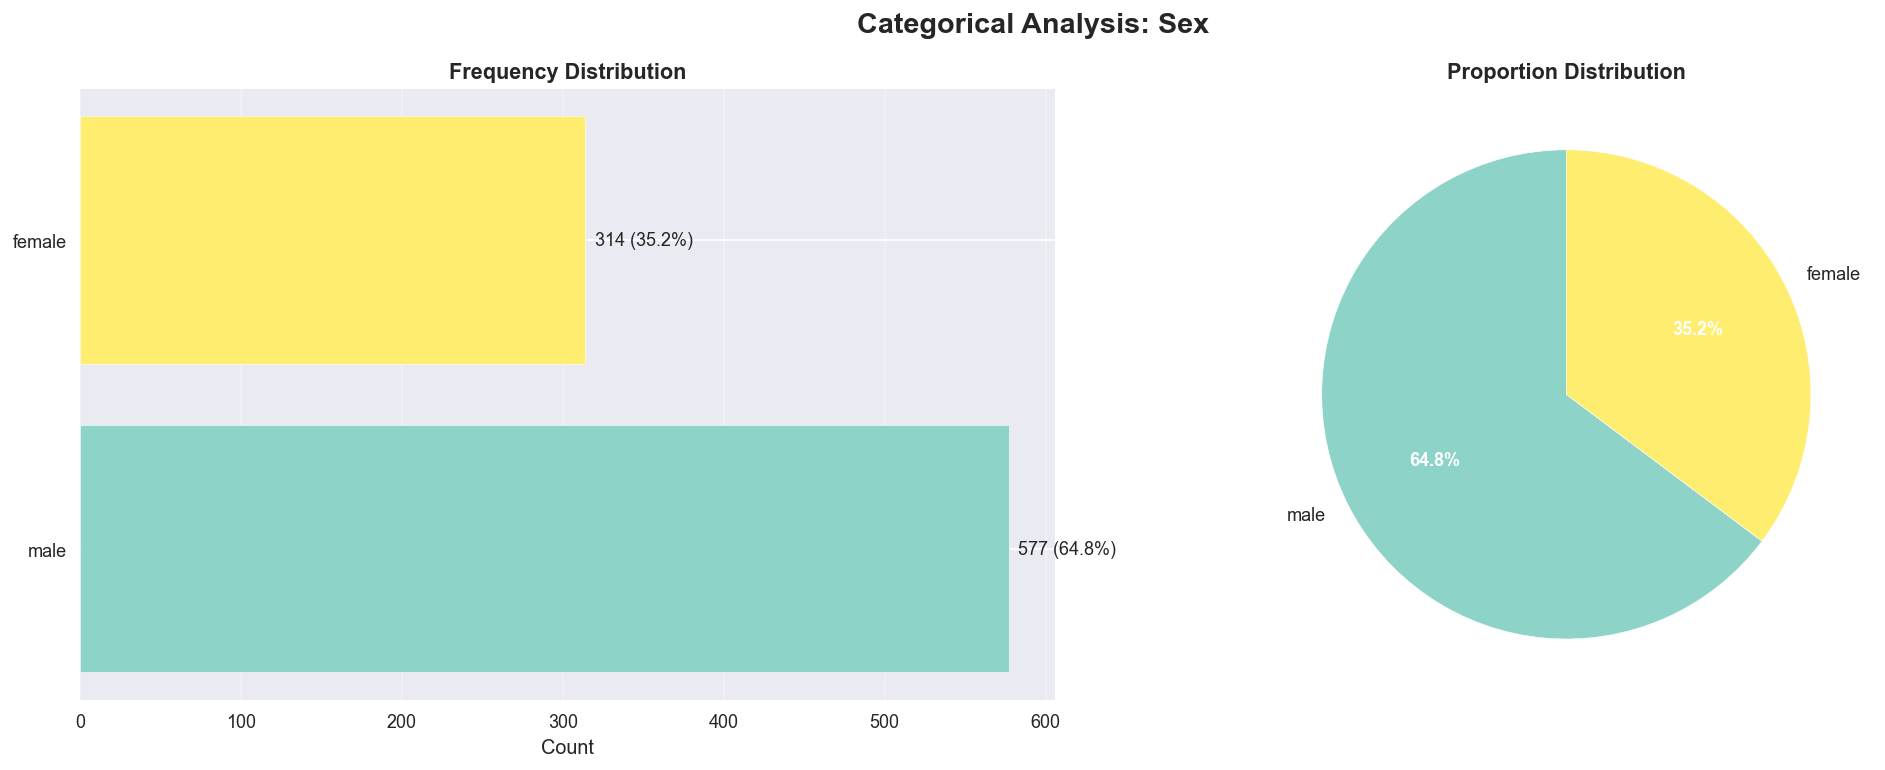


Sex - Category Summary:
Unique categories: 2
Most common: male (577 occurrences, 64.8%)
Least common: female (314 occurrences, 35.2%)
--------------------------------------------------


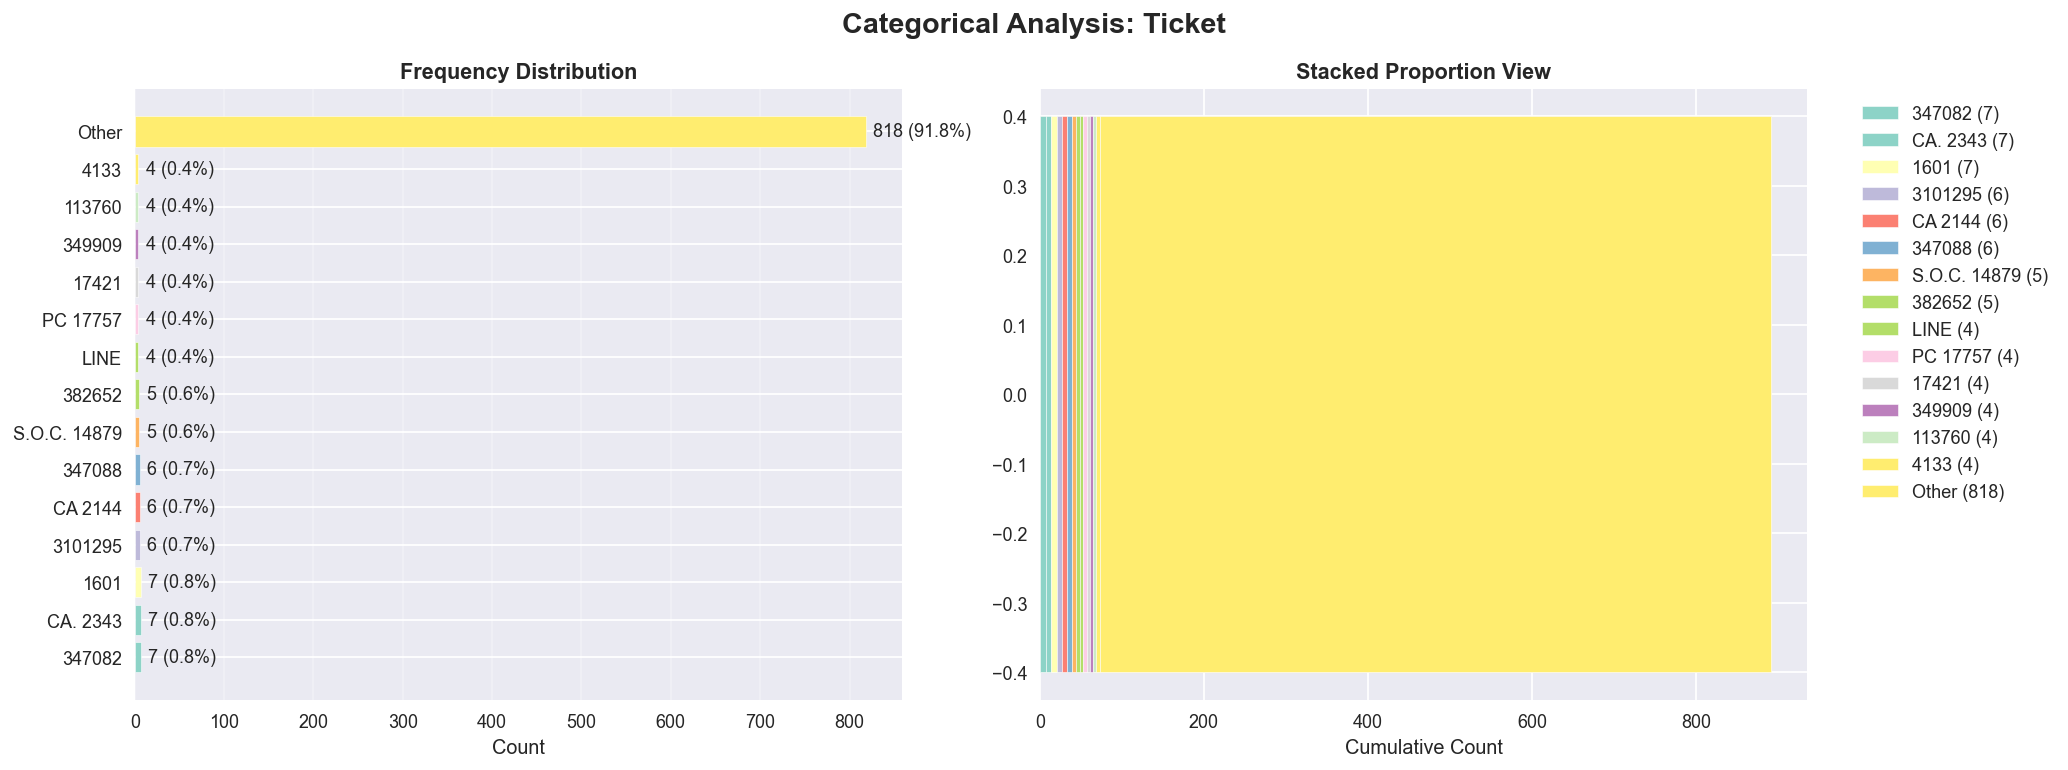


Ticket - Category Summary:
Unique categories: 15
Most common: 347082 (7 occurrences, 0.8%)
Least common: Other (818 occurrences, 91.8%)
--------------------------------------------------


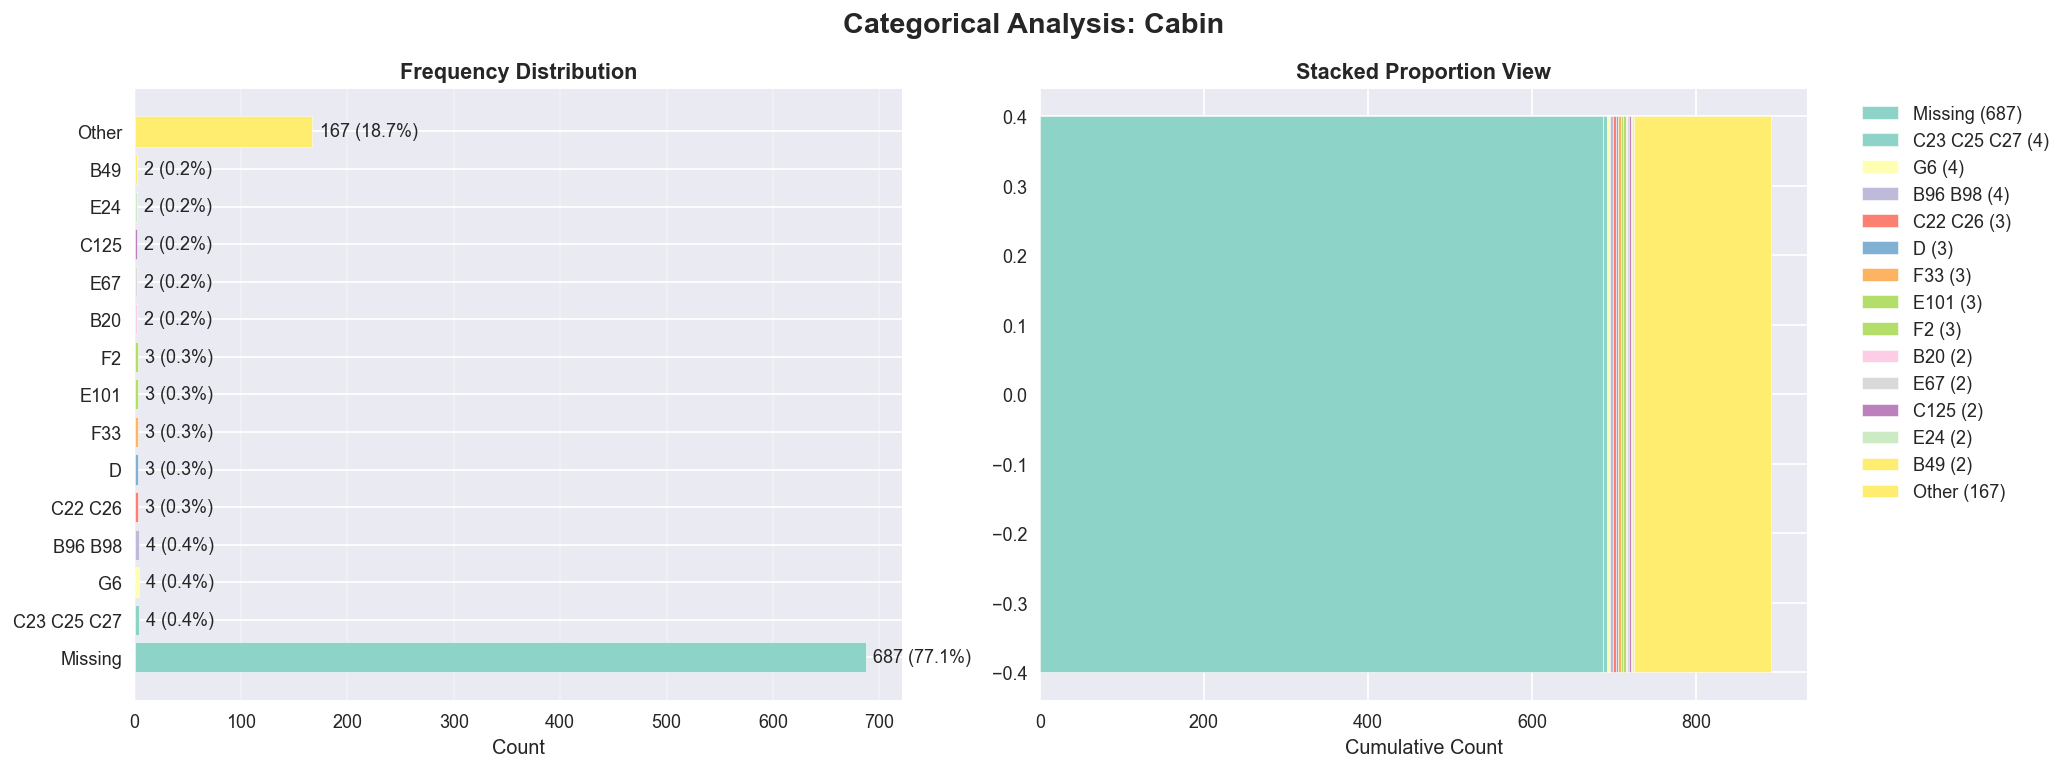


Cabin - Category Summary:
Unique categories: 15
Most common: Missing (687 occurrences, 77.1%)
Least common: Other (167 occurrences, 18.7%)
--------------------------------------------------


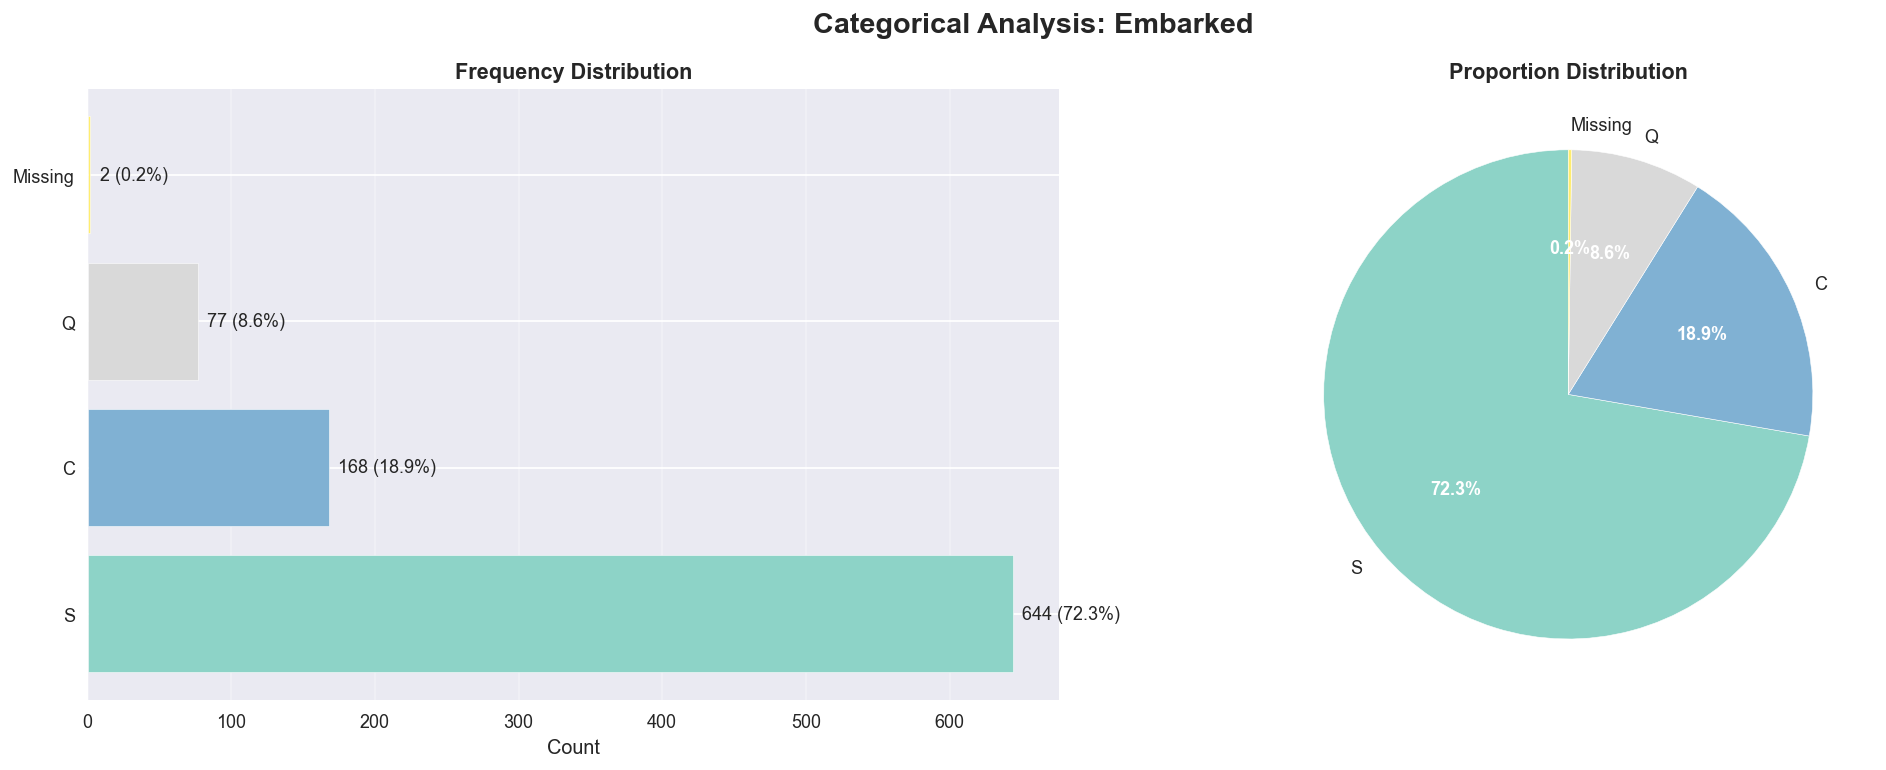


Embarked - Category Summary:
Unique categories: 4
Most common: S (644 occurrences, 72.3%)
Least common: Missing (2 occurrences, 0.2%)
--------------------------------------------------


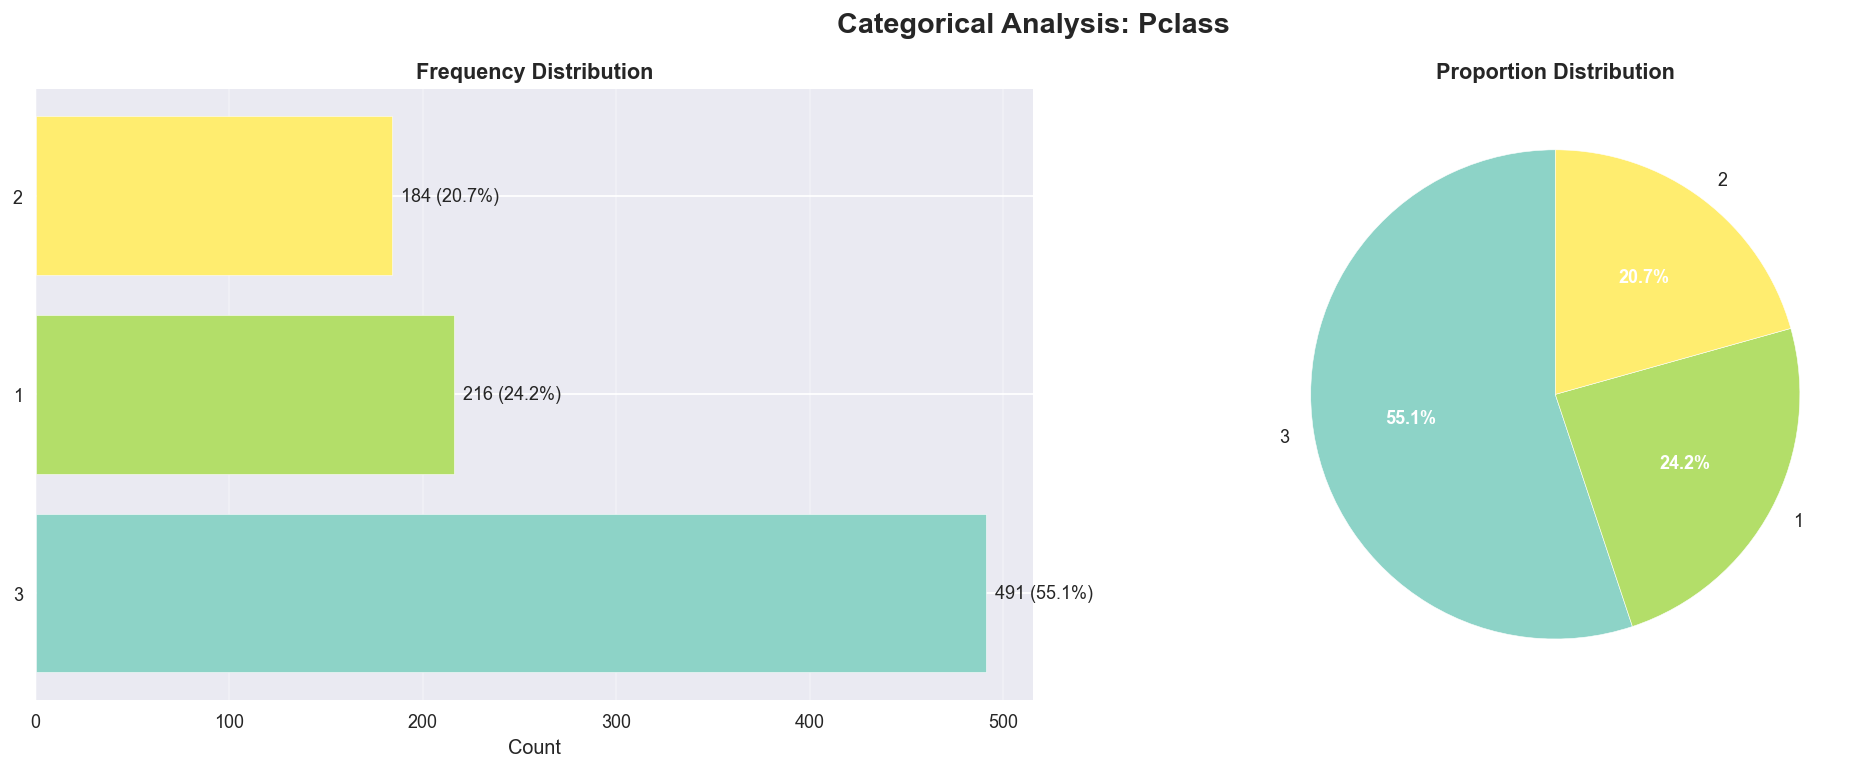


Pclass - Category Summary:
Unique categories: 3
Most common: 3 (491 occurrences, 55.1%)
Least common: 2 (184 occurrences, 20.7%)
--------------------------------------------------


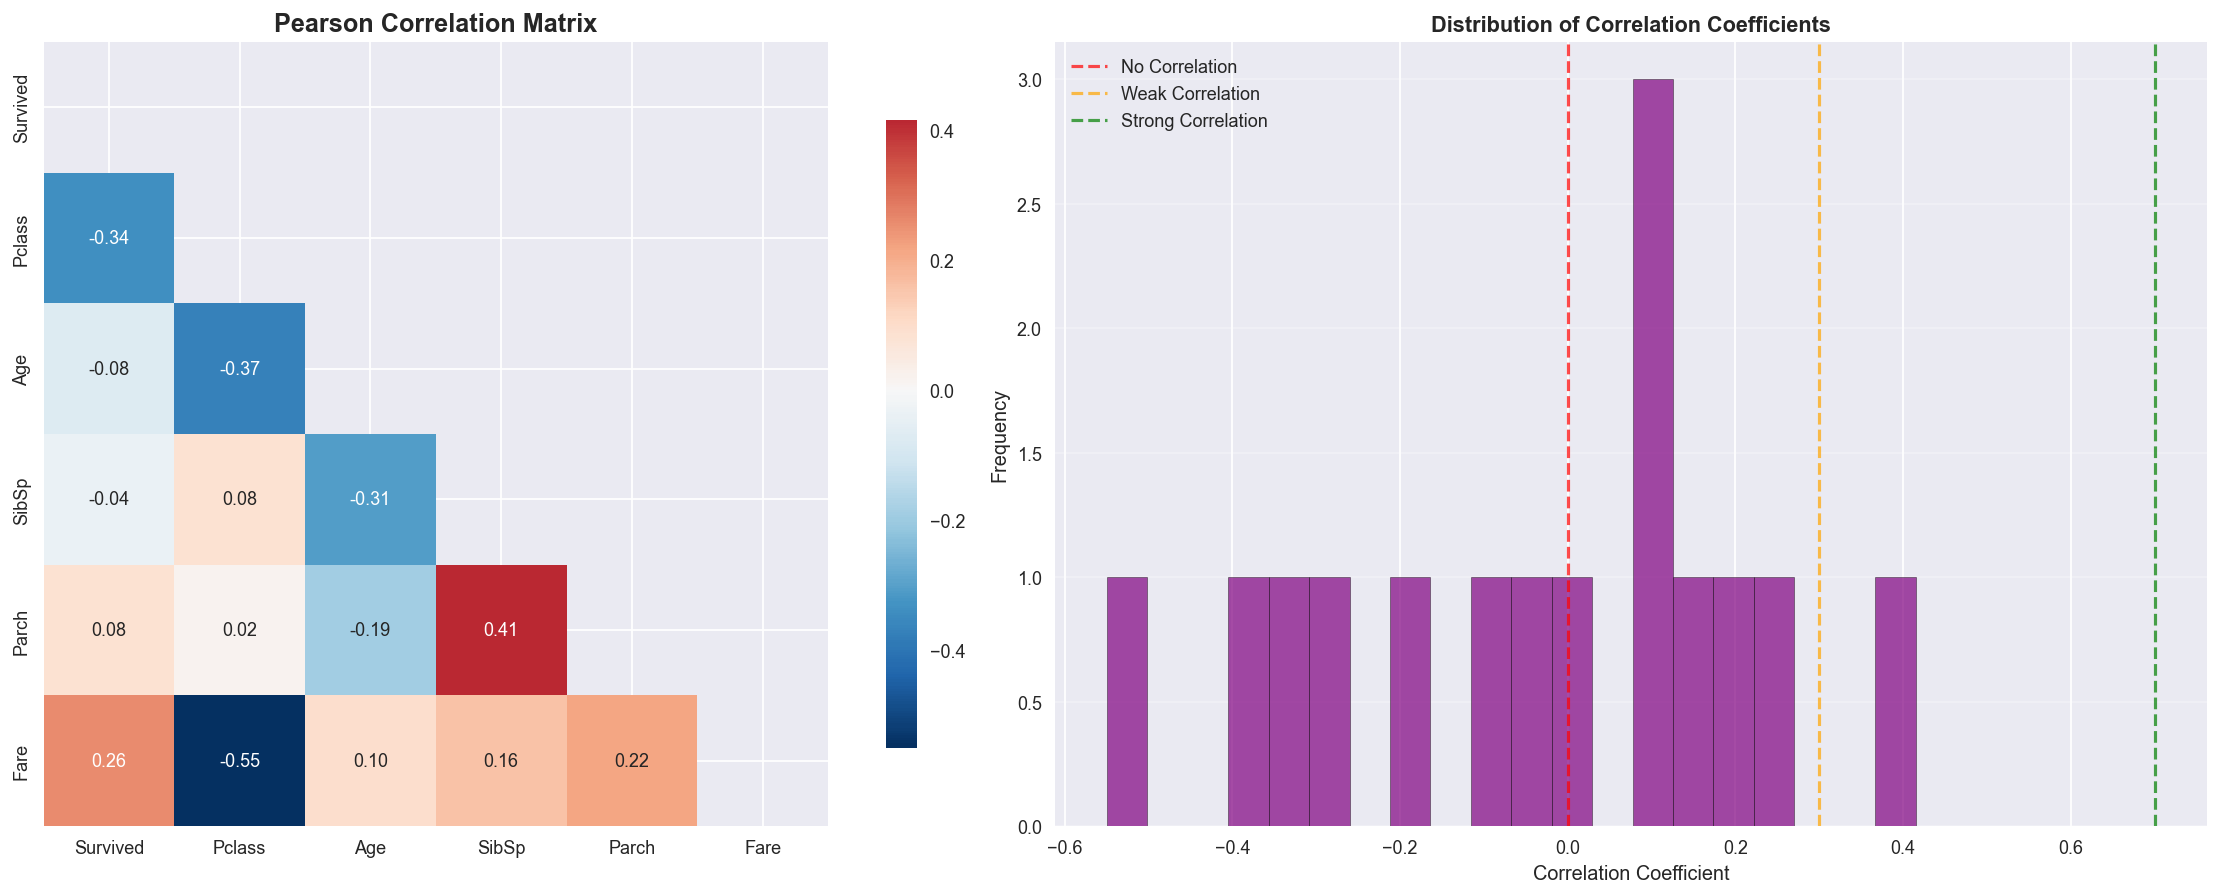


Strongest Correlations (excluding self-correlations):
Pclass <-> Fare: -0.549
SibSp <-> Parch: 0.415
Pclass <-> Age: -0.369
Survived <-> Pclass: -0.338
Age <-> SibSp: -0.308


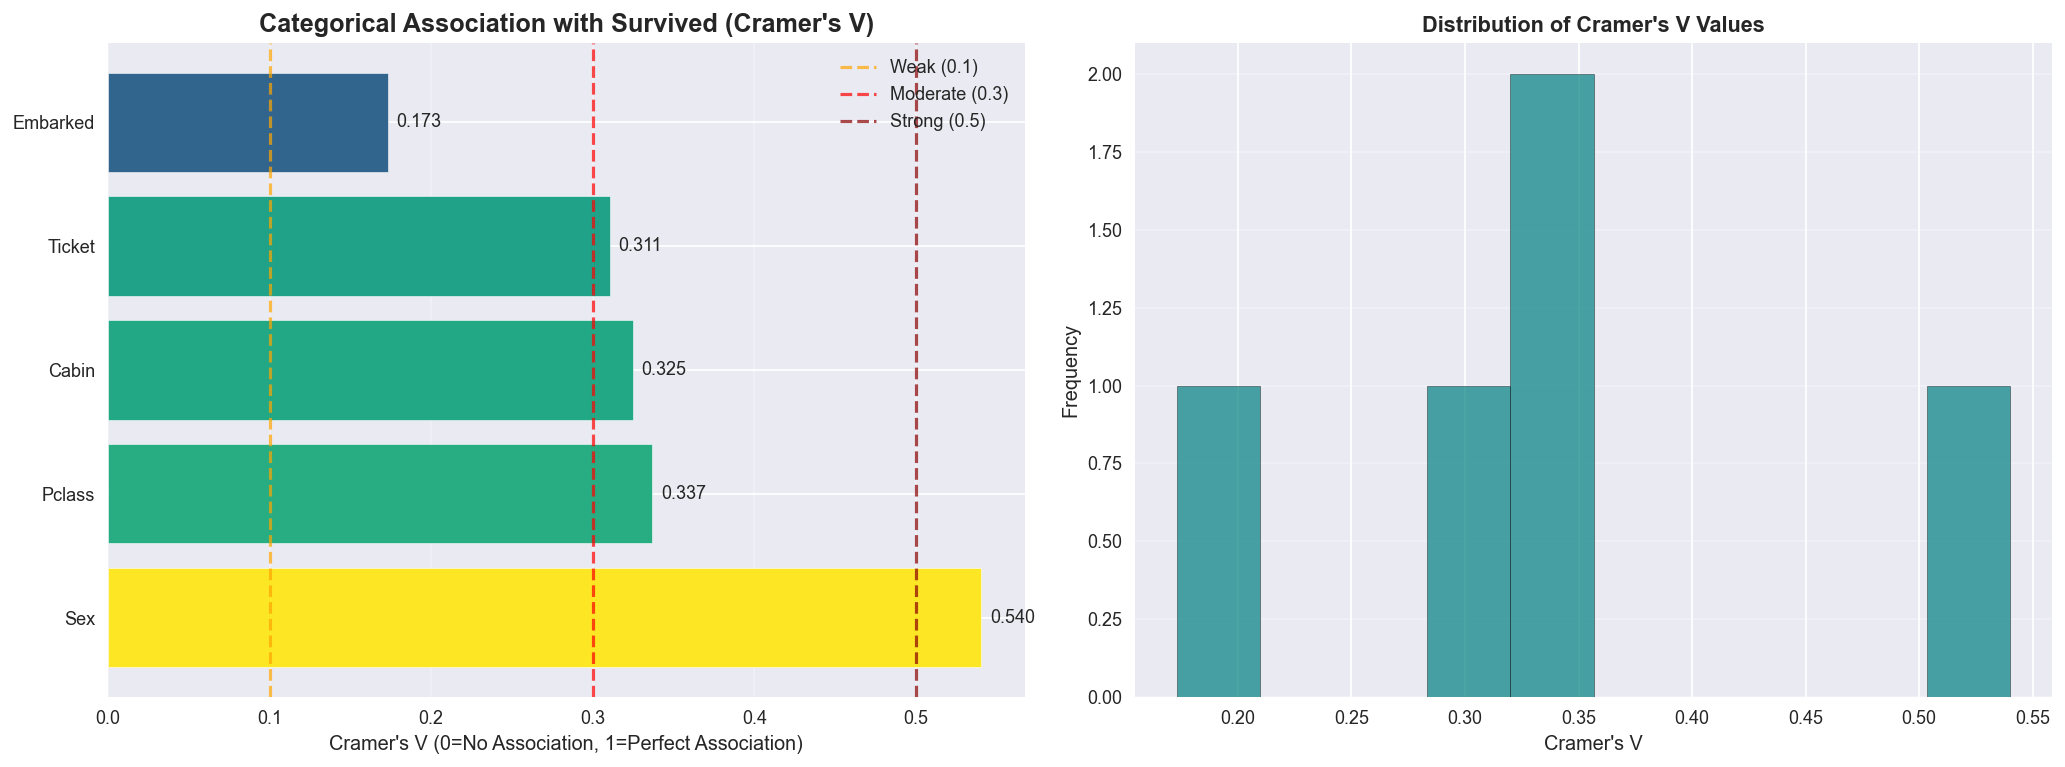


Categorical Association Analysis with Survived:
Sex            : 0.540 (Strong)
Pclass         : 0.337 (Moderate)
Cabin          : 0.325 (Moderate)
Ticket         : 0.311 (Moderate)
Embarked       : 0.173 (Weak)


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
from scipy.stats import chi2_contingency
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ===== Load your dataset =====
df = pd.read_csv("../data/raw/train.csv")  # change path if needed

# ===== Missing Data Patterns =====
def plot_missing_comprehensive(df):
    """Comprehensive missing data visualization with proper scaling"""
    miss_pct = df.isna().mean().sort_values(ascending=False)
    miss_cnt = df.isna().sum().reindex(miss_pct.index)
    
    # Only show columns with missing data
    nonzero_pct = miss_pct[miss_pct > 0]
    nonzero_cnt = miss_cnt[miss_pct > 0]
    
    if nonzero_pct.empty:
        print("No missing values found in dataset!")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Left plot: Percentage with proper scaling for small values
    bars1 = ax1.barh(nonzero_pct.index.astype(str), nonzero_pct.values, color='coral')
    ax1.set_title("Missing Values by Column (%)", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Percentage Missing", fontsize=12)
    
    # Custom formatter to show small percentages properly
    def percent_formatter(x, pos):
        if x < 0.01:
            return f'{x*100:.2f}%'
        elif x < 0.1:
            return f'{x*100:.1f}%'
        else:
            return f'{x*100:.0f}%'
    
    ax1.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        label = f'{width*100:.2f}%' if width < 0.01 else f'{width*100:.1f}%'
        ax1.text(width + max(nonzero_pct) * 0.01, bar.get_y() + bar.get_height()/2, 
                label, ha='left', va='center', fontsize=10)
    
    # Right plot: Absolute counts
    bars2 = ax2.barh(nonzero_cnt.index.astype(str), nonzero_cnt.values, color='lightblue')
    ax2.set_title("Missing Values by Column (Count)", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Number of Missing Values", fontsize=12)
    ax2.grid(axis='x', linestyle='--', alpha=0.3)
    
    # Add value labels
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(width + max(nonzero_cnt) * 0.01, bar.get_y() + bar.get_height()/2, 
                f'{int(width)}', ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_missing_heatmap(df, sample_rows=500):
    """Enhanced missing data heatmap"""
    if df.isna().sum().sum() == 0:
        print("No missing values to visualize!")
        return
        
    # Sample rows if dataset is large
    if len(df) > sample_rows:
        df_sample = df.sample(n=sample_rows, random_state=42)
    else:
        df_sample = df.copy()
    
    # Only include columns with missing data
    missing_cols = df_sample.columns[df_sample.isna().any()].tolist()
    if not missing_cols:
        print("No missing values in sample!")
        return
    
    mask = df_sample[missing_cols].isna()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(mask.T, cbar=True, cmap='RdYlBu_r', 
                xticklabels=False, yticklabels=True, ax=ax)
    ax.set_title(f'Missing Data Pattern (Sample: {len(df_sample)} rows)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Sample Index', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_missing_comprehensive(df)
plot_missing_heatmap(df)

# ===== Feature Distributions =====
def plot_numeric_distributions(df, bins=30):
    """Enhanced numeric distribution plots with multiple views"""
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Remove ID-like columns
    id_like = [c for c in num_cols if c.lower().endswith("id") or c.lower()=="passengerid"]
    num_cols = [c for c in num_cols if c not in id_like]
    
    for col in num_cols:
        series = df[col].dropna()
        if series.empty:
            continue
            
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'Distribution Analysis: {col}', fontsize=16, fontweight='bold')
        
        # Histogram
        ax1.hist(series, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_title('Histogram', fontweight='bold')
        ax1.set_xlabel(col)
        ax1.set_ylabel('Frequency')
        ax1.grid(axis='y', alpha=0.3)
        
        # Box plot
        ax2.boxplot(series, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightgreen', alpha=0.7))
        ax2.set_title('Box Plot', fontweight='bold')
        ax2.set_ylabel(col)
        ax2.grid(axis='y', alpha=0.3)
        
        # Density plot (KDE)
        series.plot.density(ax=ax3, color='orange', linewidth=2)
        ax3.set_title('Density Plot (KDE)', fontweight='bold')
        ax3.set_xlabel(col)
        ax3.set_ylabel('Density')
        ax3.grid(alpha=0.3)
        
        # Q-Q plot for normality check
        from scipy import stats
        stats.probplot(series, dist="norm", plot=ax4)
        ax4.set_title('Q-Q Plot (Normality Check)', fontweight='bold')
        ax4.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\n{col} - Summary Statistics:")
        print(f"Mean: {series.mean():.3f} | Median: {series.median():.3f}")
        print(f"Std: {series.std():.3f} | Skewness: {series.skew():.3f}")
        print(f"Min: {series.min():.3f} | Max: {series.max():.3f}")
        print("-" * 50)

def plot_categorical_analysis(df, max_categories=15, min_count=1):
    """Enhanced categorical analysis with multiple visualizations"""
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    
    # Add Pclass if it exists and is numeric but categorical
    if "Pclass" in df.columns and df["Pclass"].dtype != "object":
        cat_cols.append("Pclass")
    
    for col in cat_cols:
        # Clean and count values
        series_clean = df[col].astype(str).replace('nan', 'Missing').replace('None', 'Missing')
        vc = series_clean.value_counts()
        
        # Filter out very rare categories if too many exist
        if len(vc) > max_categories:
            top_cats = vc.iloc[:max_categories-1]
            other_count = vc.iloc[max_categories-1:].sum()
            if other_count > 0:
                top_cats['Other'] = other_count
            vc = top_cats
        
        # Skip if all categories have very low counts
        if vc.max() < min_count:
            continue
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'Categorical Analysis: {col}', fontsize=16, fontweight='bold')
        
        # Horizontal bar chart (better for long category names)
        colors = plt.cm.Set3(np.linspace(0, 1, len(vc)))
        bars = ax1.barh(range(len(vc)), vc.values, color=colors)
        ax1.set_yticks(range(len(vc)))
        ax1.set_yticklabels(vc.index.astype(str))
        ax1.set_title('Frequency Distribution', fontweight='bold')
        ax1.set_xlabel('Count')
        ax1.grid(axis='x', alpha=0.3)
        
        # Add count labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            percentage = (width / vc.sum()) * 100
            label = f'{int(width)} ({percentage:.1f}%)'
            ax1.text(width + vc.max() * 0.01, bar.get_y() + bar.get_height()/2, 
                    label, ha='left', va='center', fontsize=10)
        
        # Pie chart (only if reasonable number of categories)
        if len(vc) <= 8:
            wedges, texts, autotexts = ax2.pie(vc.values, labels=vc.index, autopct='%1.1f%%', 
                                              colors=colors, startangle=90)
            ax2.set_title('Proportion Distribution', fontweight='bold')
            
            # Improve text readability
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
        else:
            # Use stacked horizontal bar for many categories
            ax2.barh([0], [vc.sum()], color='lightgray')
            cumsum = 0
            for i, (cat, count) in enumerate(vc.items()):
                ax2.barh([0], [count], left=cumsum, color=colors[i], 
                        label=f'{cat} ({count})')
                cumsum += count
            ax2.set_title('Stacked Proportion View', fontweight='bold')
            ax2.set_xlabel('Cumulative Count')
            ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n{col} - Category Summary:")
        print(f"Unique categories: {len(vc)}")
        print(f"Most common: {vc.index[0]} ({vc.iloc[0]} occurrences, {vc.iloc[0]/vc.sum()*100:.1f}%)")
        if len(vc) > 1:
            print(f"Least common: {vc.index[-1]} ({vc.iloc[-1]} occurrences, {vc.iloc[-1]/vc.sum()*100:.1f}%)")
        print("-" * 50)

plot_numeric_distributions(df)
plot_categorical_analysis(df, max_categories=15)

# ===== Enhanced Correlation Analysis =====
def plot_correlation_analysis(df):
    """Comprehensive correlation analysis"""
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.empty:
        print("No numeric columns found for correlation analysis!")
        return
    
    # Remove ID columns
    id_cols = [c for c in numeric_df.columns if c.lower().endswith("id")]
    numeric_df = numeric_df.drop(columns=id_cols)
    
    if numeric_df.shape[1] < 2:
        print("Not enough numeric columns for correlation analysis!")
        return
    
    correlation_matrix = numeric_df.corr(method="pearson")
    
    # Create mask for upper triangle to avoid redundancy
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Enhanced heatmap
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8}, ax=ax1)
    ax1.set_title('Pearson Correlation Matrix', fontsize=14, fontweight='bold')
    
    # Correlation strength distribution
    # Get upper triangle values (excluding diagonal)
    corr_values = correlation_matrix.values[np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)]
    corr_values = corr_values[~np.isnan(corr_values)]
    
    if len(corr_values) > 0:
        ax2.hist(corr_values, bins=20, alpha=0.7, color='purple', edgecolor='black')
        ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No Correlation')
        ax2.axvline(x=0.3, color='orange', linestyle='--', alpha=0.7, label='Weak Correlation')
        ax2.axvline(x=0.7, color='green', linestyle='--', alpha=0.7, label='Strong Correlation')
        ax2.set_title('Distribution of Correlation Coefficients', fontweight='bold')
        ax2.set_xlabel('Correlation Coefficient')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print strongest correlations
    print("\nStrongest Correlations (excluding self-correlations):")
    corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if not np.isnan(corr_val):
                corr_pairs.append((correlation_matrix.columns[i], 
                                 correlation_matrix.columns[j], 
                                 abs(corr_val), corr_val))
    
    corr_pairs.sort(key=lambda x: x[2], reverse=True)
    for feat1, feat2, abs_corr, corr in corr_pairs[:5]:
        print(f"{feat1} <-> {feat2}: {corr:.3f}")

plot_correlation_analysis(df)

# ===== Enhanced Cramer's V Analysis =====
def cramers_v(x, y):
    """Calculate Cramer's V statistic for categorical association"""
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.size == 0:
        return np.nan
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    if denom <= 0:
        return np.nan
    return sqrt(phi2corr / denom)

def analyze_categorical_associations(df, target="Survived"):
    """Enhanced categorical association analysis"""
    if target not in df.columns:
        print(f"Target column '{target}' not found!")
        return
    
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    if "Pclass" in df.columns and df["Pclass"].dtype != "object":
        cat_cols.append("Pclass")
    
    # Remove target from features if it's in the list
    if target in cat_cols:
        cat_cols.remove(target)
    
    results = []
    for col in cat_cols:
        try:
            v = cramers_v(df[col].astype(str).fillna('Missing'), 
                         df[target].astype(str))
            results.append((col, v))
        except Exception as e:
            print(f"Error calculating Cramer's V for {col}: {e}")
            results.append((col, np.nan))
    
    results_df = pd.DataFrame(results, columns=["Feature", "CramersV"])
    results_df = results_df.dropna().sort_values("CramersV", ascending=False)
    
    if results_df.empty:
        print("No valid Cramer's V calculations possible!")
        return
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot of Cramer's V values
    colors = plt.cm.viridis(results_df['CramersV'] / results_df['CramersV'].max())
    bars = ax1.barh(results_df['Feature'], results_df['CramersV'], color=colors)
    ax1.set_title(f"Categorical Association with {target} (Cramer's V)", 
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel("Cramer's V (0=No Association, 1=Perfect Association)")
    ax1.grid(axis='x', alpha=0.3)
    
    # Add threshold lines
    ax1.axvline(x=0.1, color='orange', linestyle='--', alpha=0.7, label='Weak (0.1)')
    ax1.axvline(x=0.3, color='red', linestyle='--', alpha=0.7, label='Moderate (0.3)')
    ax1.axvline(x=0.5, color='darkred', linestyle='--', alpha=0.7, label='Strong (0.5)')
    ax1.legend()
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width + results_df['CramersV'].max() * 0.01, 
                bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=10)
    
    # Distribution of Cramer's V values
    ax2.hist(results_df['CramersV'], bins=10, alpha=0.7, color='teal', edgecolor='black')
    ax2.set_title("Distribution of Cramer's V Values", fontweight='bold')
    ax2.set_xlabel("Cramer's V")
    ax2.set_ylabel("Frequency")
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nCategorical Association Analysis with {target}:")
    print("=" * 50)
    for _, row in results_df.iterrows():
        strength = "Strong" if row['CramersV'] >= 0.5 else "Moderate" if row['CramersV'] >= 0.3 else "Weak" if row['CramersV'] >= 0.1 else "Very Weak"
        print(f"{row['Feature']:15s}: {row['CramersV']:.3f} ({strength})")
    
    return results_df

# Run the analysis
cramers_results = analyze_categorical_associations(df, target="Survived")